In [35]:
import pandas
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from glob import glob
from scipy import stats
from copy import deepcopy
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.sandbox.stats.multicomp import multipletests
sys.path.insert(0,'./code/')
import CrossDecomp as XD

# annoyingly, you'll need to clone the git repo from my previous paper because I 
# recycle some code from that repo.
# https://github.com/illdopejake/Hippocampus_AP_Axis

# change this to the location of that repo
sys.path.insert(0,'/Users/jacobv/git/Hippocampus_AP_Axis/')
import HAP_Utils as hap

In [36]:
%matplotlib inline

# Initialize data

In [37]:
# Where to save figures
fig_dir = './figures/'

In [38]:
# Generated in NB1
bigdf = pandas.read_csv('data/expression.csv') 
allendir = '/Users/jacobv/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
# Generated in NB2
gdf = pandas.read_csv('data/PLS_GXp_gdf.csv',index_col=0) # Generated in NB2
bigdf.index = gdf.index
bigdf.drop('well_id',axis=1,inplace=True)

In [39]:
# recover the PCA results
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf),index = gdf.index)

# Examine components

In [40]:
# fit model to all the data
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [41]:
def inverse_pls_pca_transform(component_transform,component_space,PLS_rotations):
    A = deepcopy(component_transform.T)
    A -= component_space.mean(0)
    A /= component_space.std(0) 
    solution = np.dot(PLS_rotations.T,A.T)
    
    return solution

In [42]:
gene_space = []
for i in range(3):
    wts = inverse_pls_pca_transform(pcamod.components_, 
                                                pca_tfm, 
                                                pls_mod.x_rotations_[:,i])
    gene_space.append(wts.reshape(len(wts),1))
gene_weights = pandas.DataFrame(np.concatenate(gene_space,axis=1))
gene_weights.columns = ['C1','C2','C3']
gene_weights.loc[:,'gene_symbol'] = bigdf.columns

In [33]:
gene_weights[['gene_symbol','C1','C2','C3']].to_csv('./tables/STable_Weights.csv',index=False)

In [12]:
# Bootstrap PLS model fitting to make bootstrap ratios
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)
n_iter = 1000
bsrx, bsry, allx_bs, ally_bs = XD.bootstrap_features(PLSRegression(n_components=3), 
                                                  pls_mod, 
                                                  pca_tfm, 
                                                  full_y, 
                                                  n_iterations=n_iter,
                                                    mode='rotations')

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


#### Get C1 X Genes

First, let's plot the component loadings including confidence intervals

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T

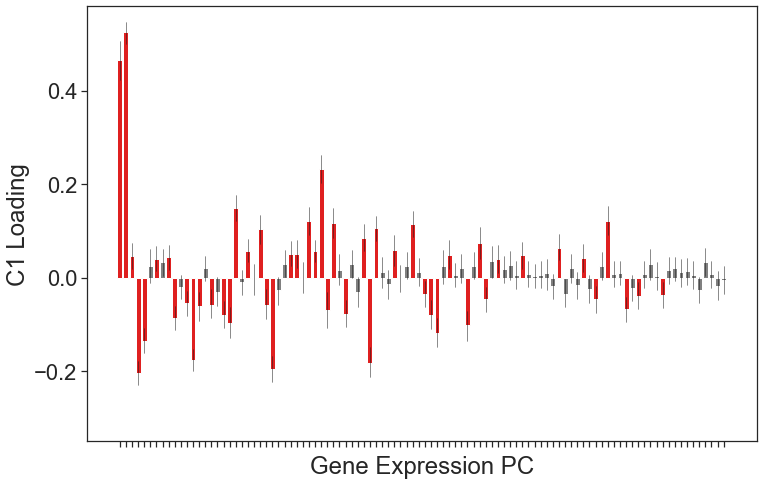

In [13]:
# create plot df
plotr = pandas.concat([pandas.Series(allx_bs[0].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*n_iter)],
                      axis=1)
plotr.columns = ['Loading','Component']
sns.set(font_scale=2)
sns.set_style('ticks')

# color based on whether loadings are significantly greater than 0
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]]

# plot
plt.subplots(figsize=(12,8))
g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors,
             ci=None)

# plot confidence intervals
for i in plotr.Component.unique():
    dist = sorted(plotr[plotr.Component==i].Loading.values)
    cil,ciu = dist[50],dist[-50]
    plt.plot([i,i],[cil,ciu],c='k',lw=.5)
    
# decorations
plt.xlabel('Gene Expression PC')
plt.ylabel('C1 Loading')
plt.ylim(-.35,.58)
g.set_xticklabels([None for x in range(100)])
#plt.savefig(os.path.join(fig_dir,'C1_XWeights.pdf'),bbox_inches='tight')

In [14]:
# manually regularize loadings by setting features to 0 that aren't significantly different from 0
sigs = multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]
new_loading = [pls_mod.x_rotations_[x,0] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
#new_loading = [pls_mod.x_loadings_[x,0] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]

In [15]:
# blast the regularized PLS loadings back into gene space

def inverse_pls_pca_transform(component_transform,component_space,PLS_rotations):
    A = deepcopy(component_transform.T)
    A -= component_space.mean(0)
    A /= component_space.std(0) 
    solution = np.dot(PLS_rotations.T,A.T)
    
    return solution

gene_space_C1 = inverse_pls_pca_transform(pcamod.components_, pca_tfm, np.array(new_loading))

In [16]:
# blast the regularized PLS loadings back into gene space
newc1 = pandas.concat([pandas.Series(gene_space_C1), pandas.Series(bigdf.columns)],
                      axis=1)
newc1.columns = [0,'gene_symbol']

In [17]:
# create a df with gene symbol and gene name
probe_index = pandas.DataFrame(probes,copy=True)
probe_index.index = probe_index.gene_symbol.values
for i,row in newc1.iterrows():
    if row['gene_symbol'] in probe_index.index:
        nm = probe_index.loc[row['gene_symbol'],'gene_name']
        if type(nm) == pandas.core.series.Series:
            newc1.loc[i,'gene_name'] = nm.values[0]
        elif pandas.notnull(nm):
            newc1.loc[i,'gene_name'] = nm

In [18]:
newc1.sort_values(0,ascending=False)

0 gene_symbol                                          gene_name
7856   0.028420         MET  met proto-oncogene (hepatocyte growth factor r...
7492   0.024828         LXN                                            latexin
12808  0.024740     ST3GAL6  ST3 beta-galactoside alpha-2,3-sialyltransfera...
838    0.023677        ARL9                     ADP-ribosylation factor-like 9
13662  0.022749     TMEM249                                                NaN
...         ...         ...                                                ...
5243  -0.021123       GPR20                      G protein-coupled receptor 20
3025  -0.023950       CTXN3                                         cortexin 3
489   -0.024942      AMDHD1                 amidohydrolase domain containing 1
14757 -0.025724       WFDC1                   WAP four-disulfide core domain 1
10446 -0.032893       PRRX1                          paired related homeobox 1

[15633 rows x 3 columns]

In [19]:
# build larger df to collect all C
allcomps = pandas.DataFrame(newc1,copy=True)
allcomps.columns = ['C1','gene_symbol','gene_name']

In [20]:
# get C1 expression for each sample
c1_xp = pls_mod.transform(pca_tfm)[:,0]
gdf.loc[:,'C1_Expression'] = c1_xp

In [17]:
# create a volume with cubes around each coordinate indicating C1 expression at that coordinate
# We'll use this later to do surface analysis

input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'c1_ROTATION'
mni_pth = './data/MNI152_T1_1mm.nii.gz'
wdir = './outputs/'
if not os.path.isdir(wdir):
    os.mkdir(wdir)
gcx_img = hap.make_expression_image(c1_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

#### Get C2 X Genes

Now repeat all those steps with C2

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T

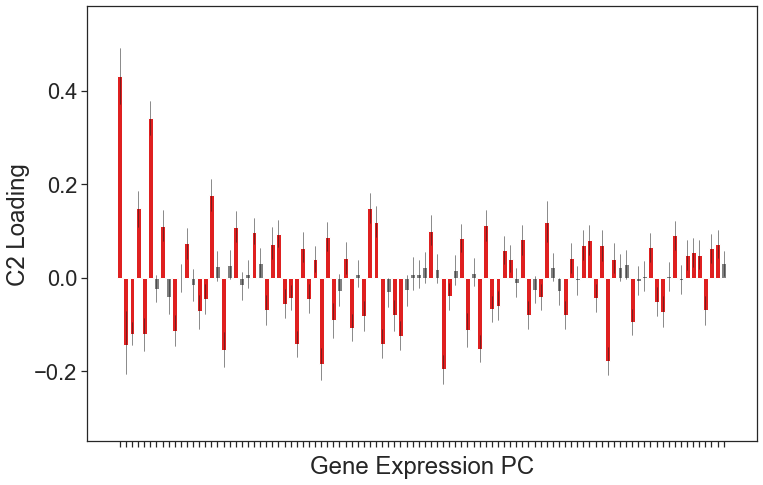

In [21]:
plotr = pandas.concat([pandas.Series(allx_bs[1].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*n_iter)],
                      axis=1)
plotr.columns = ['Loading','Component']
sns.set(font_scale=2)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]]
plt.subplots(figsize=(12,8))
g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors,
             ci=None)
for i in plotr.Component.unique():
    dist = sorted(plotr[plotr.Component==i].Loading.values)
    cil,ciu = dist[50],dist[-50]
    plt.plot([i,i],[cil,ciu],c='k',lw=.5)
plt.xlabel('Gene Expression PC')
plt.ylabel('C2 Loading')
plt.ylim(-.35,.58)
g.set_xticklabels([None for x in range(100)])
#plt.savefig(os.path.join(fig_dir,'C2_XWeights.pdf'),bbox_inches='tight')

In [22]:
sigs = multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]
#new_loading = [pls_mod.x_loadings_[x,1] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
new_loading = [pls_mod.x_rotations_[x,1] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
allcomps.loc[:,'C2'] = inverse_pls_pca_transform(pcamod.components_, pca_tfm, np.array(new_loading))
allcomps.sort_values('C2')

C1 gene_symbol  \
7936   0.020616         MGP   
7856   0.028420         MET   
13280  0.018040       TDRD1   
9429   0.013428    PAX8-AS1   
7492   0.024828         LXN   
...         ...         ...   
4620  -0.004058    FLJ30901   
14227 -0.010048       TUNAR   
5500  -0.011456        HCN4   
489   -0.024942      AMDHD1   
10446 -0.032893       PRRX1   

                                               gene_name        C2  
7936                                  matrix Gla protein -0.049167  
7856   met proto-oncogene (hepatocyte growth factor r... -0.041018  
13280                          tudor domain containing 1 -0.037829  
9429                                                 NaN -0.034787  
7492                                             latexin -0.033686  
...                                                  ...       ...  
4620                    uncharacterized protein FLJ30901  0.032232  
14227                                                NaN  0.032257  
5500   hyperpolarization activated cyclic nucleotide-...  0.032997  
489                   amidohydrolase domain containing 1  0.043567  
10446                          paired related homeobox 1  0.045387  

[15633 rows x 4 columns]

In [23]:
c2_xp = pls_mod.transform(pca_tfm)[:,1]
gdf.loc[:,'C2_Expression'] = c2_xp

In [21]:
nm = 'c2_ROTATION'
mni_pth = './data/MNI152_T1_1mm.nii.gz'
wdir = './outputs/'
if not os.path.isdir(wdir):
    os.mkdir(wdir)
gcx_img = hap.make_expression_image(c2_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

#### Get C3 X Genes

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T

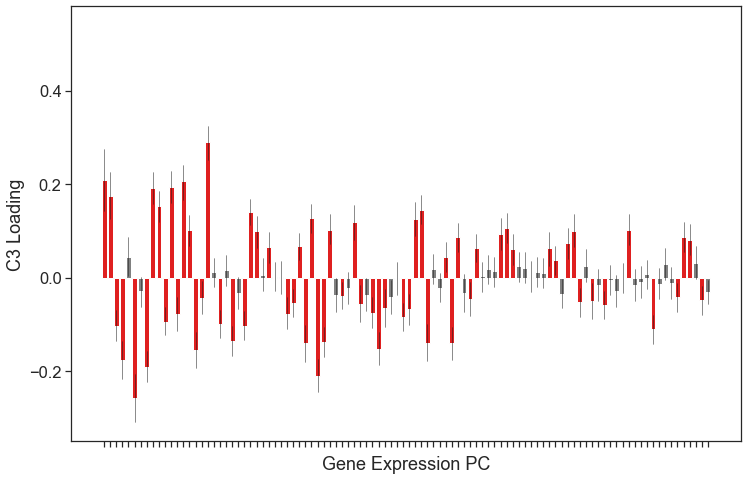

In [22]:
plotr = pandas.concat([pandas.Series(allx_bs[2].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*n_iter)],
                      axis=1)
plotr.columns = ['Loading','Component']
sns.set(font_scale=1.5)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]]
plt.subplots(figsize=(12,8))
g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors,
             ci=None)
for i in plotr.Component.unique():
    dist = sorted(plotr[plotr.Component==i].Loading.values)
    cil,ciu = dist[50],dist[-50]
    plt.plot([i,i],[cil,ciu],c='k',lw=.5)
plt.xlabel('Gene Expression PC')
plt.ylabel('C3 Loading')
plt.ylim(-.35,.58)
g.set_xticklabels([None for x in range(100)])
#plt.savefig(os.path.join(fig_dir,'C3_XWeights.pdf'),bbox_inches='tight')

In [24]:
sigs = multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]
new_loading = [pls_mod.x_rotations_[x,2] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
allcomps.loc[:,'C3'] = inverse_pls_pca_transform(pcamod.components_, pca_tfm, np.array(new_loading))
allcomps.sort_values('C3')

C1 gene_symbol  \
7936   0.020616         MGP   
11576  0.011389      SAPCD2   
13791  0.002374    TNFSF13B   
3100   0.006447     CYP26B1   
10043  0.004236        PNMT   
...         ...         ...   
13323 -0.014798       TEX26   
7005  -0.009843   LINC01158   
4803  -0.011397        G0S2   
379   -0.015413        AIRE   
14647 -0.010064       VSTM1   

                                               gene_name        C2        C3  
7936                                  matrix Gla protein -0.049167 -0.030331  
11576                                                NaN -0.015885 -0.028291  
13791  tumor necrosis factor (ligand) superfamily, me... -0.005217 -0.026039  
3100   cytochrome P450, family 26, subfamily B, polyp... -0.016404 -0.025279  
10043             phenylethanolamine N-methyltransferase  0.002462 -0.024641  
...                                                  ...       ...       ...  
13323                                testis expressed 26  0.023314  0.027457  
7005                                                 NaN  0.010176  0.027570  
4803                                       G0/G1switch 2 -0.001999  0.027814  
379                                 autoimmune regulator  0.011396  0.028075  
14647        V-set and transmembrane domain containing 1  0.014556  0.036154  

[15633 rows x 5 columns]

In [25]:
c3_xp = pls_mod.transform(pca_tfm)[:,2]
gdf.loc[:,'C3_Expression'] = c3_xp

In [25]:
nm = 'c3_ROTATION'
mni_pth = './data/MNI152_T1_1mm.nii.gz'
wdir = './outputs/'
if not os.path.isdir(wdir):
    os.mkdir(wdir)
gcx_img = hap.make_expression_image(c3_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

#### Rotated vs original weights

<AxesSubplot:>

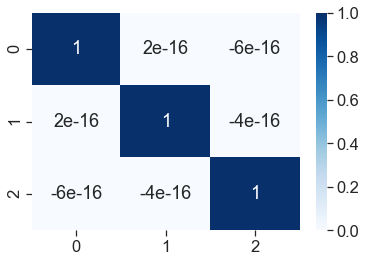

In [150]:
sns.heatmap(np.corrcoef(gdf[['C1_Expression','C2_Expression','C3_Expression']].T),
           annot=True,cmap='Blues',fmt='.1g')

In [118]:
jnk = pandas.read_csv('tables/all_comps.csv')
jnk = jnk[['C1','C2','C3']]
wrong = np.dot(bigdf,jnk)

<AxesSubplot:>

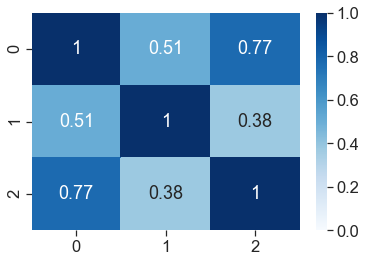

In [151]:
sns.heatmap(np.corrcoef(np.dot(bigdf,jnk).T),annot=True,cmap='Blues',vmin=0,vmax=1)

In [111]:
right = gdf[['C1_Expression','C2_Expression','C3_Expression']]

In [120]:
diff = wrong-right

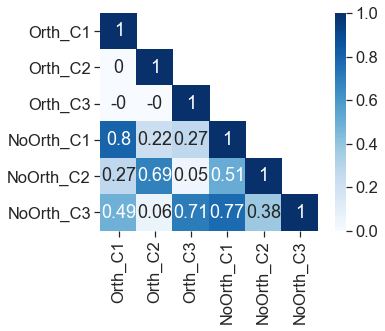

In [178]:
jnk = pandas.concat([pandas.DataFrame(right.values,copy=True),
                    pandas.DataFrame(wrong,columns=['NoOrth_C1','NoOrth_C2','NoOrth_C3'])],
                    axis=1)
jnk.columns = ['Orth_C1','Orth_C2','Orth_C3','NoOrth_C1','NoOrth_C2','NoOrth_C3',]
jnk= pandas.DataFrame(np.corrcoef(jnk.T),index=jnk.columns,columns=jnk.columns)
mask = np.zeros_like(jnk, dtype=np.bool)
mask[np.triu_indices_from(mask,k=1)] = True
sns.heatmap(jnk.round(2),annot=True,fmt='.2g',cmap='Blues',vmin=0,vmax=1,square=True,mask=mask)
plt.savefig(os.path.join(fig_dir,'OrthvNoOrth_Heatmap.pdf'),
            bbox_inches='tight')

#### Similarity of tails

In [35]:
# First, look at expression correlation of each tail

tailvecs = pandas.DataFrame(index=gdf.index)
tgenes = {}
for i in range(1,4):
    genes = allcomps.sort_values('C%s'%i).head(130).gene_symbol.values
    tgenes.update({'C%s_head'%i:genes})
    tailvecs.loc[:,'C%s_head'%i] = bigdf[genes].mean(1).values
    genes = allcomps.sort_values('C%s'%i).tail(130).gene_symbol.values
    tgenes.update({'C%s_tail'%i:genes})
    tailvecs.loc[:,'C%s_tail'%i] = bigdf[genes].mean(1).values
    

<AxesSubplot:>

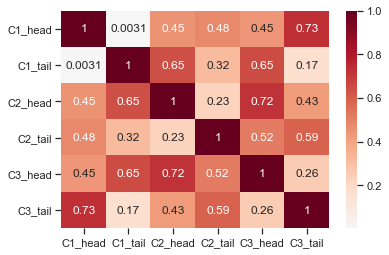

In [40]:
sns.set_context('notebook',font_scale=1)
sns.heatmap(pandas.DataFrame(np.corrcoef(tailvecs.T),
                             index=tailvecs.columns,columns=tailvecs.columns),
            annot=True,center=0,cmap='RdBu_r')

In [42]:
tailvecs.head()

C1_head   C1_tail   C2_head   C2_tail   C3_head   C3_tail
2756  0.661309  0.445616  0.559953  0.552895  0.446249  0.635237
2757  0.467339  0.426500  0.459846  0.413816  0.520290  0.457975
2758  0.441780  0.463548  0.466825  0.421269  0.496402  0.457717
2759  0.411648  0.398580  0.384120  0.457282  0.408184  0.414446
2760  0.422960  0.480654  0.484885  0.539260  0.494749  0.500468

_____C1_head_____


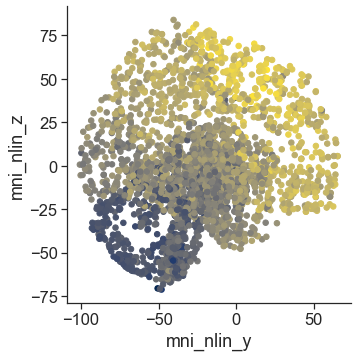

_____C1_tail_____


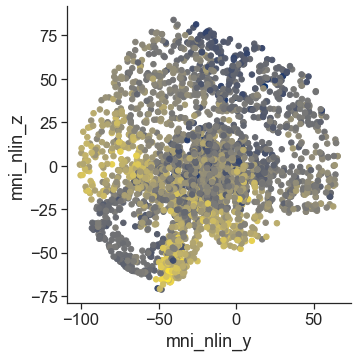

_____C2_head_____


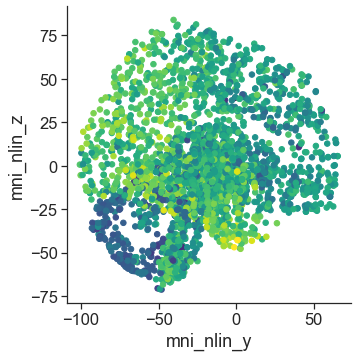

_____C2_tail_____


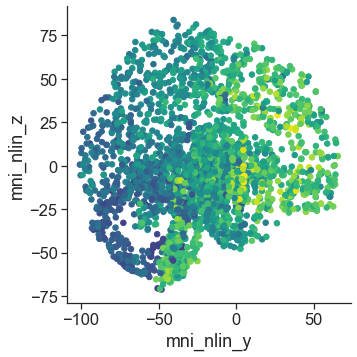

_____C3_head_____


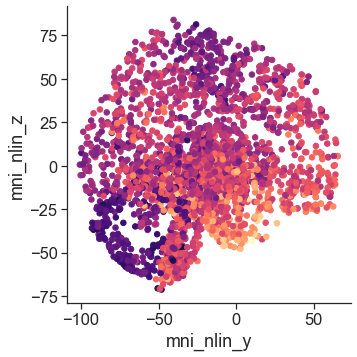

_____C3_tail_____


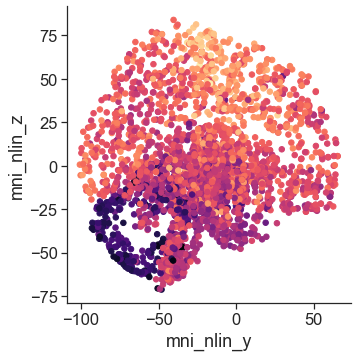

In [61]:
from nilearn import plotting

input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
    
nm = 'jnk'
mni_pth = './data/MNI152_T1_1mm.nii.gz'
wdir = './outputs/'
for n,col in enumerate(tailvecs.columns):
    print('_____%s_____'%col)
#     gcx_img = hap.make_expression_image(tailvecs[col].values, input_coords, mni_pth, 
#                                         wdir, nm, 5, return_img=True)
#     plotting.plot_stat_map(gcx_img,cmap='viridis',cut_coords=[-24,-10,-7])
#     plt.show()
    i = n//2
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = tailvecs[col].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='viridis')
    plt.show()

In [43]:
gdf.loc[:,'avg_expr'] = bigdf.mean(1).values

In [ ]:
gdf.brain_divison

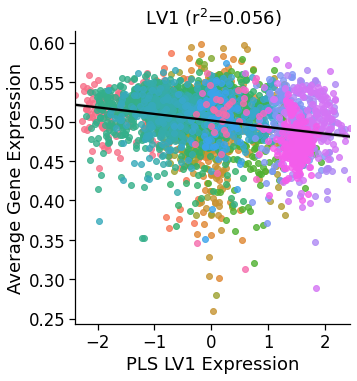

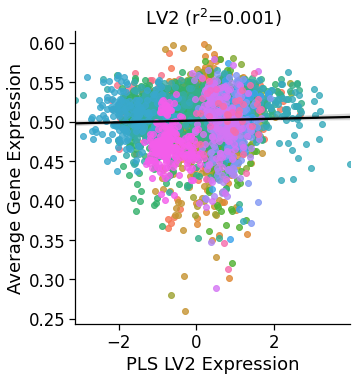

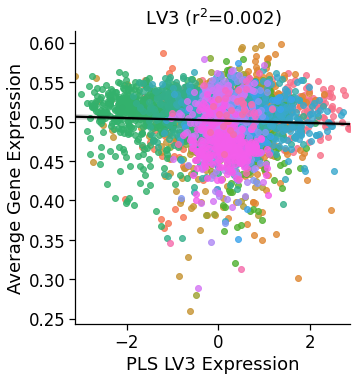

In [65]:
sns.set_context('notebook',font_scale=1.5)
for i in range(1,4):
    sns.lmplot(x='C%s_orig'%i,y='avg_expr',hue='brain_divison',data=gdf,fit_reg=False,legend=False)
    sns.regplot(x='C%s_orig'%i,y='avg_expr',data=gdf,color='black',marker='',
                scatter_kws={'alpha':0.3})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    r = stats.pearsonr(gdf['C%s_orig'%i].values,gdf.avg_expr.values)[0]
    plt.title('LV%s (r$^2$=%s)'%(i,round(r**2,3)))
    plt.xlabel('PLS LV%s Expression'%i)
    plt.ylabel('Average Gene Expression')
    plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/PostFix/subfigs/C%s_v_average.pdf'%i,
               bbox_inches='tight')
    plt.show()

KeyError: 'brain_divison'

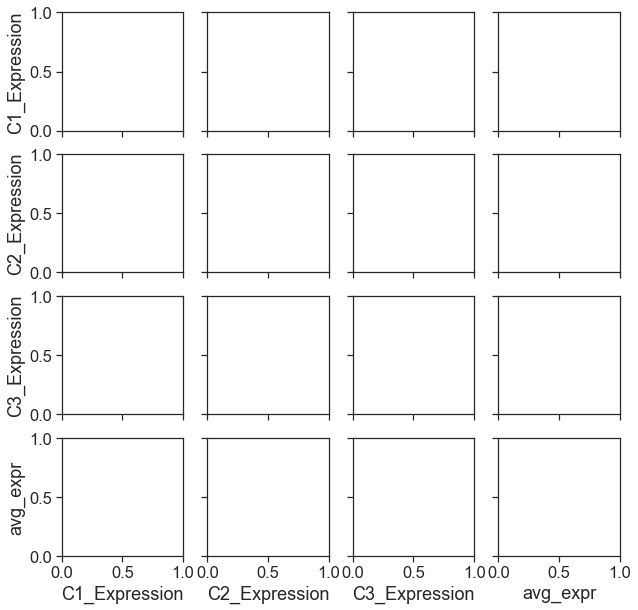

In [181]:
sns.pairplot(data=gdf[['C1_Expression','C2_Expression','C3_Expression','avg_expr']],
             hue='brain_divison')

('C1_head', 'C1_tail')
n overlapping genes = 0
not enough overlap
('C1_head', 'C2_head')
n overlapping genes = 1
not enough overlap
('C1_head', 'C2_tail')
n overlapping genes = 27


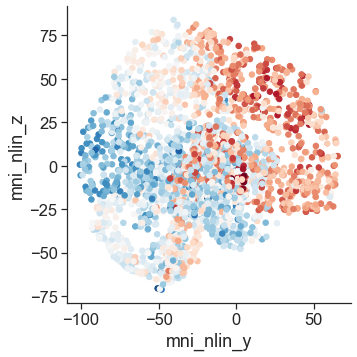

('C1_head', 'C3_head')
n overlapping genes = 1
not enough overlap
('C1_head', 'C3_tail')
n overlapping genes = 28


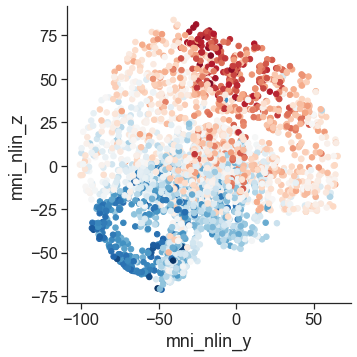

('C1_tail', 'C2_head')
n overlapping genes = 33


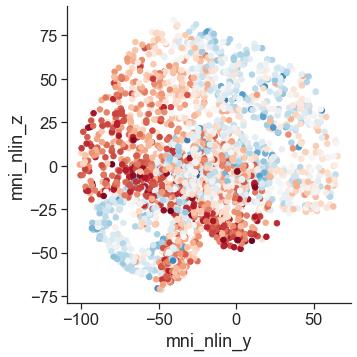

('C1_tail', 'C2_tail')
n overlapping genes = 2
not enough overlap
('C1_tail', 'C3_head')
n overlapping genes = 26


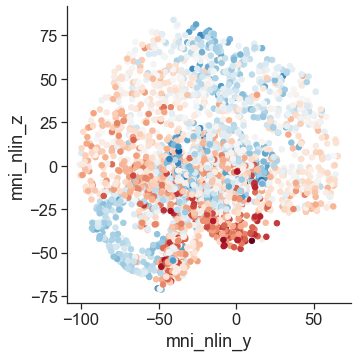

('C1_tail', 'C3_tail')
n overlapping genes = 0
not enough overlap
('C2_head', 'C2_tail')
n overlapping genes = 0
not enough overlap
('C2_head', 'C3_head')
n overlapping genes = 29


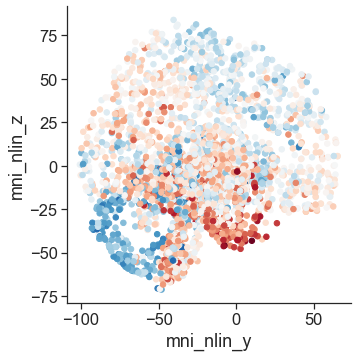

('C2_head', 'C3_tail')
n overlapping genes = 1
not enough overlap
('C2_tail', 'C3_head')
n overlapping genes = 1
not enough overlap
('C2_tail', 'C3_tail')
n overlapping genes = 27


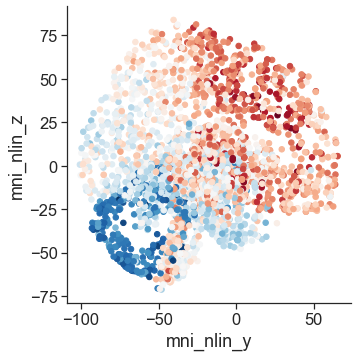

('C3_head', 'C3_tail')
n overlapping genes = 0
not enough overlap


In [75]:
# Next plot overlap
import itertools

for combo in itertools.combinations(tgenes.keys(),2):
    print(combo)
    overlap = list(set(tgenes[combo[0]]) & set(tgenes[combo[1]]))
    print('n overlapping genes =',len(overlap))
    if len(overlap) < 3:
        print('not enough overlap')
        continue
    else:
        vec = bigdf[overlap].mean(1).values
        
    cmap = sns.color_palette('RdBu_r',as_cmap=True)
    sg = vec
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='viridis')
    plt.show()

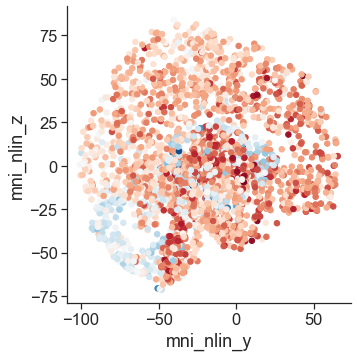

In [78]:
supers = list(set(list(tgenes['C1_head']) + list(tgenes['C1_tail'])) &\
              set(list(tgenes['C2_head']) + list(tgenes['C2_tail'])) &\
              set(list(tgenes['C3_head']) + list(tgenes['C3_tail'])))
vec = bigdf[supers].mean(1).values

cmap = sns.color_palette('RdBu_r',as_cmap=True)
sg = vec
scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
norm = Normalize(vmin=np.min(scaled_sg), 
                               vmax=np.max(scaled_sg))
cscale = cmap(norm(scaled_sg))

# plot
g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
           data=gdf, fit_reg=False, 
           scatter_kws={"s": 30,'color':cscale},
          palette='viridis')
plt.show()

#### Table S1

In [47]:
allcomps = allcomps.reindex(columns=['gene_symbol','gene_name','C1','C2','C3'])

In [48]:
# ID top 0.83% of genes as significantly contributing
# Thats 5% / two tails = 2.5% / three comparisons = 0.83%
thr = (0.05 / 2) / 3
n_sig = int(round(len(allcomps) * thr))
for col in ['C1','C2','C3']:
    ind = allcomps.sort_values(col,ascending=True).index[:n_sig].tolist() + \
          allcomps.sort_values(col,ascending=False).index[:n_sig].tolist()
    allcomps.loc[ind,'%s_genelist'%col] = 1
    allcomps.loc[allcomps['%s_genelist'%col]!=1,'%s_genelist'%col] = 0
allcomps = allcomps.sort_index()

In [49]:
allcomps.to_csv('./tables/all_comps_ROTATION.csv')

# Projection
Here we will visualize the spatial and genomic components (i.e. the latent variates from the PLS model)

In [26]:
# Fit the the PLS model again
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))
pls_mod = PLSRegression(n_components=3)
#full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

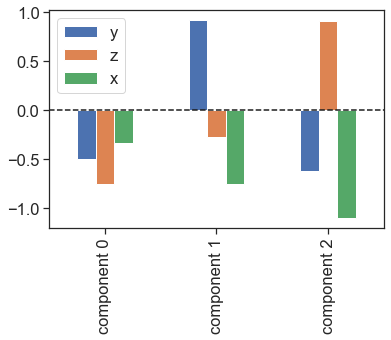

In [51]:
# visualize the y (spatial) weights
sns.set_context('notebook',font_scale=1.5)
pandas.DataFrame(pls_mod.y_rotations_, 
                 index=['y','z','x'],
                 columns=['component %s'%x for x in range(3)]).T.plot.bar()
plt.axhline(0,c='k',ls='--')
#plt.savefig(os.path.join(fig_dir,'y_weights.pdf'),bbox_inches='tight')

In [10]:
tfm_X,tfm_Y = pls_mod.transform(pca_tfm, full_y)

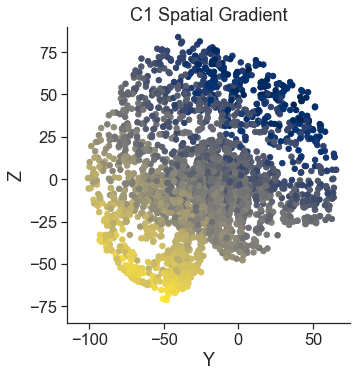

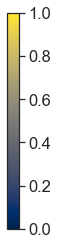

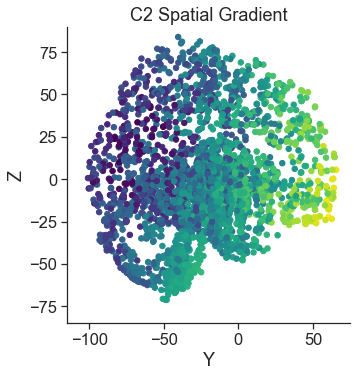

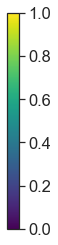

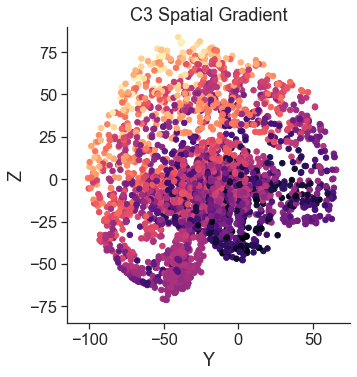

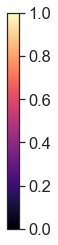

In [54]:
# PLOT SPATIAL GRADIENTS (Latent Y variables)
pals = ['cividis','viridis','magma']

# for each component
for i in range(pls_mod.y_weights_.shape[0]):
    # colors
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = tfm_Y[:,i]
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    gdf.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    # plot
    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='magma')
    
    # decorate
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Spatial Gradient'%(i+1))
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    #plt.savefig(os.path.join(fig_dir,'brain_plot_SpatialC%s_YZ.png'%(i+1)),
    #            bbox_inches='tight')

    # colorbar
    a = np.array([[0,1]])
    plt.figure(figsize=(.2, 5))
    img = plt.imshow(a, cmap=pals[i])
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    cbar = plt.colorbar(orientation="vertical", cax=cax)
    newticks = [round(norm.inverse(x),1) for x in cbar.get_ticks()]
    cbar.set_ticks(cbar.get_ticks())
    cbar.set_ticklabels(newticks)
    plt.savefig(os.path.join(fig_dir,'brain_plot_component%s_cbar.png'%(i+1)),
                                bbox_inches='tight')

    plt.show()




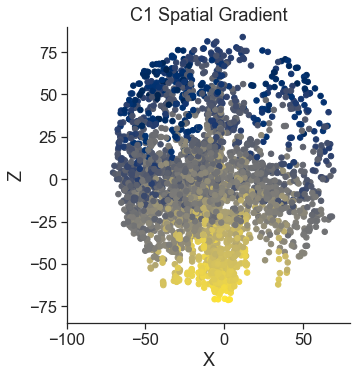

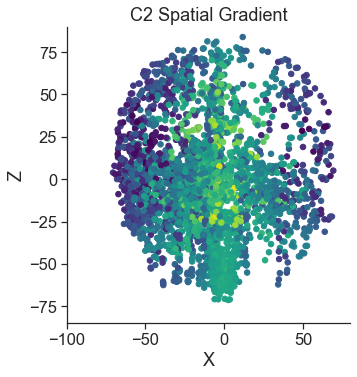

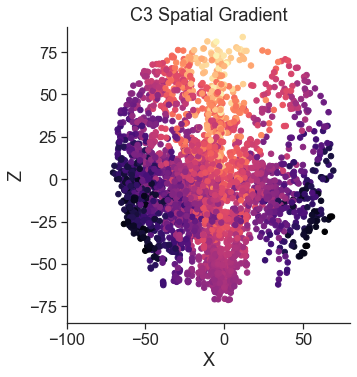

In [56]:
# same thing but from another view
for i in range(pls_mod.y_weights_.shape[0]):
    # colors
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = tfm_Y[:,i]
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    gdf.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='viridis')
    
    # decorate
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title('C%s Spatial Gradient'%(i+1))
    plt.ylim(-85,90)
    plt.xlim(-80,80)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.savefig(os.path.join(fig_dir,'brain_plot_SpatialC%s_XZ.png'%(i+1)),
                bbox_inches='tight')



In [ ]:
alltops = list(set(np.concatenate(list(tgenes.values()))))

In [93]:
(len(shar)/len(RC))*100

57.14285714285714

In [116]:
set(alltops)

{'ABHD12B',
 'ACKR1',
 'ACTC1',
 'ACTL8',
 'ACVR1C',
 'ADAM19',
 'ADAMTS8',
 'ADAMTS9',
 'ADAMTSL1',
 'ADCYAP1',
 'ADGRF5',
 'ADGRL3',
 'ADM5',
 'ADRA1A',
 'AEBP1',
 'AFAP1L1',
 'AFAP1L2',
 'AGT',
 'AHCYL2',
 'AIM2',
 'AIRE',
 'AKAIN1',
 'AKAP13',
 'ALKAL2',
 'ALPL',
 'AMDHD1',
 'AMIGO2',
 'ANKRD18DP',
 'ANKRD37',
 'ANKRD65',
 'ANTXR1',
 'APMAP',
 'ARHGAP25',
 'ARHGAP29',
 'ARHGAP4',
 'ARHGAP6',
 'ARID5A',
 'ARL6IP1',
 'ARL9',
 'ART3',
 'ASB2',
 'ASB5',
 'ASGR2',
 'ATP2C2',
 'BACH2',
 'BCL11B',
 'BDKRB2',
 'BEAN1',
 'BHLHE22',
 'BLM',
 'BMP8B',
 'BRINP3',
 'BSPRY',
 'BST2',
 'C14orf132',
 'C15orf59',
 'C1QTNF12',
 'C1R',
 'C1S',
 'C2',
 'C2orf27A',
 'C8orf34',
 'C9orf24',
 'CA4',
 'CABCOCO1',
 'CACNA2D3',
 'CADPS2',
 'CALB2',
 'CALCRL',
 'CAMK2D',
 'CAMK2N2',
 'CAPN12',
 'CAPRIN2',
 'CARTPT',
 'CASP5',
 'CAV2',
 'CAVIN3',
 'CCBE1',
 'CCDC158',
 'CCDC173',
 'CCDC6',
 'CCDC88B',
 'CD38',
 'CD6',
 'CD86',
 'CD8A',
 'CDH12',
 'CDH13',
 'CDH6',
 'CDHR1',
 'CDK2AP1',
 'CDKN2A',
 'CDT1',
 'CE

In [101]:
1

RC shared: ['ETV5', 'MEIS2', 'NR2E1', 'PAX6', 'POU3F1', 'POU3F3', 'TLE1', 'ZIC1'] 57%
CR shared: ['NR2F2', 'TSHZ1'] 12%
Other shared: [] 0%
Other shared: 26%


In [110]:
len([x for x in abs(allcomps['C%s'%i].values) if x > val]) / len(allcomps)

0.210836051941406

RC 0.062
CR 0.114
Others 0.405


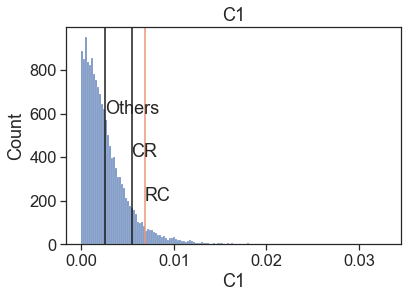

RC 0.044
CR 0.2
Others 0.124


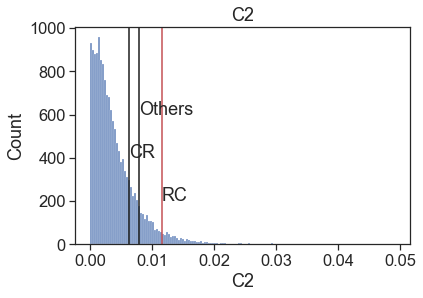

RC 0.088
CR 0.172
Others 0.211


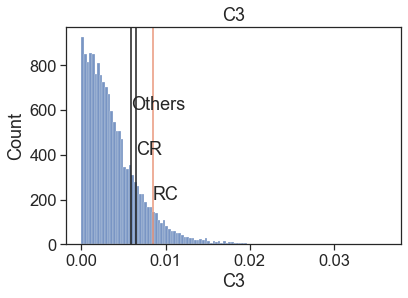

In [114]:
for i in range(1,4):
    sns.histplot(abs(allcomps['C%s'%i]))
    count = 1
    for nm,gset in dict(zip(['RC','CR','Others'],[RC,CR,Others])).items():
        val = abs(allcomps[allcomps.gene_symbol.isin(gset)]['C%s'%i]).mean()
        p = len([x for x in abs(allcomps['C%s'%i].values) if x > val]) / len(allcomps)
        print(nm,round(p,3))
        if p < 0.05:
            plt.axvline(val,c='r')
        elif p < 0.1:
            plt.axvline(val,c='darksalmon')
        else:
            plt.axvline(val,c='k')
        plt.text(val,200*count,nm)
        count+=1
    plt.title('C%s'%i)
    plt.show()

In [180]:
# LEAVING THIS HERE FOR NOW

# ##### THIS IS IT!!!!! (THANX ALEX!!)
# A = deepcopy(pcamod.components_.T)
# A -= pca_tfm.mean(0)
# A /= pca_tfm.std(0) 
# # A *= pca_tfm.std(0)
# # A += pca_tfm.mean(0)
# solution = np.dot(pls_mod.x_rotations_.T,A.T)
# B = deepcopy(bigdf)
# # B -= B.mean(0)
# # B /= B.std(0)
# contA = np.dot(solution,B.T)

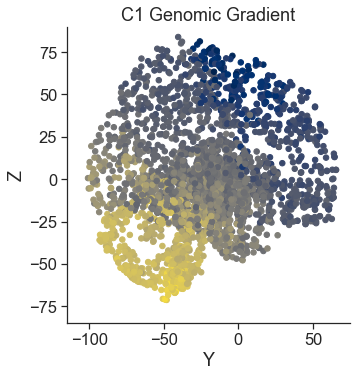

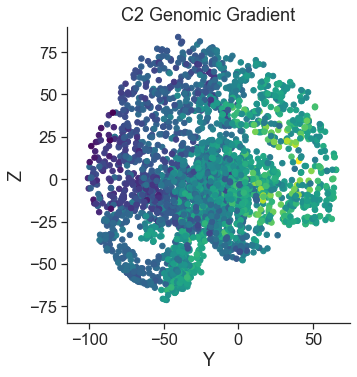

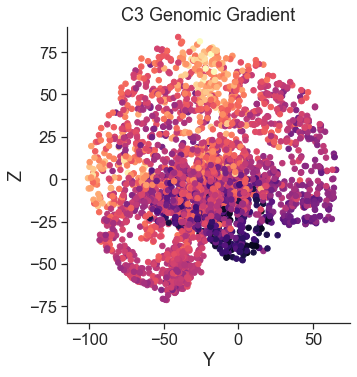

In [53]:
# now the genomic gradients (latent X variables)
sns.set_context('notebook',font_scale=1.5)

# for each component
for i in range(pls_mod.y_weights_.shape[0]):
    # colors
    cmap = sns.color_palette(pals[i],as_cmap=True)
    #sg = tfm_X[:,i]
    sg = gdf['C%s_Expression'%(i+1)].values
    #sg = diff.values[:,i]
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  )
    
    # decorate
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Genomic Gradient'%(i+1))
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    #plt.savefig(os.path.join(fig_dir,'brain_plot_GenomicC%s_YZ.png'%(i+1)),bbox_inches='tight')



In [121]:
diff.shape

(3466, 3)

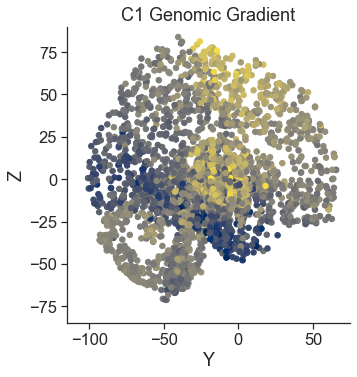

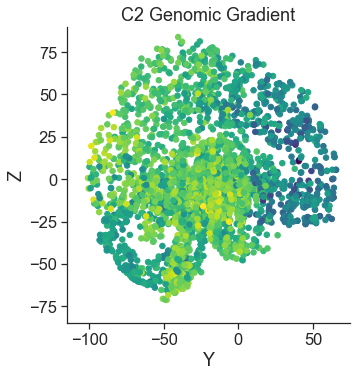

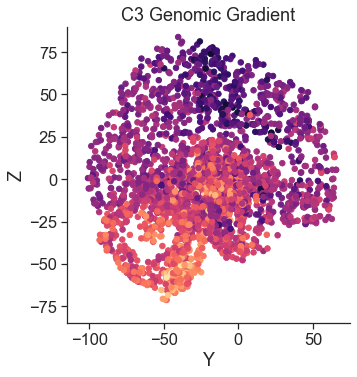

In [133]:
# now the genomic gradients (latent X variables)
sns.set_context('notebook',font_scale=1.5)

# for each component
for i in range(pls_mod.y_weights_.shape[0]):
    # colors
    cmap = sns.color_palette(pals[i],as_cmap=True)
    #sg = tfm_X[:,i]
    sg = diff.values[:,i]
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  )
    
    # decorate
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Genomic Gradient'%(i+1))
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.savefig(os.path.join(fig_dir,'brain_plot_DiffC%s_YZ.png'%(i+1)),bbox_inches='tight')



In [125]:
right.min()

C1_Expression   -2.387308
C2_Expression   -3.104520
C3_Expression   -3.117394
dtype: float64

In [127]:
from sklearn.preprocessing import StandardScaler

zWrong = StandardScaler().fit_transform(wrong)

In [128]:
diff = zWrong - right

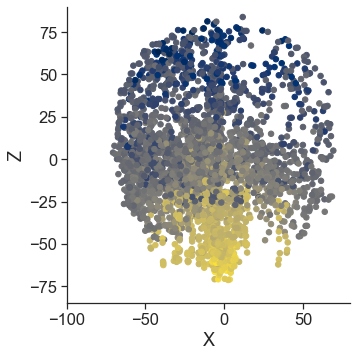

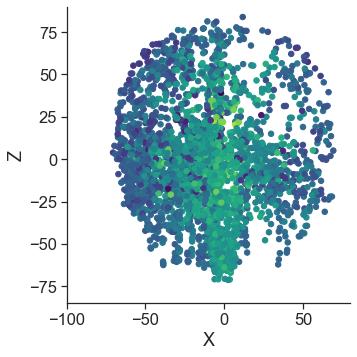

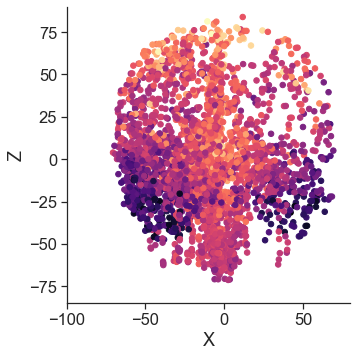

In [134]:
# and the other view

for i in range(pls_mod.y_weights_.shape[0]):
    # colors
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = tfm_X[:,i]
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    # decorate
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.ylim(-85,90)
    plt.xlim(-80,80)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.savefig(os.path.join(fig_dir,'brain_plot_GenomicC%s_XZ.png'%(i+1)),bbox_inches='tight')



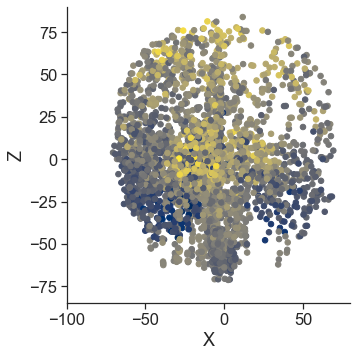

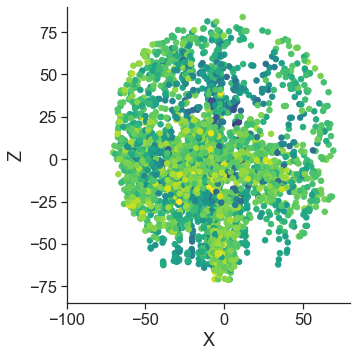

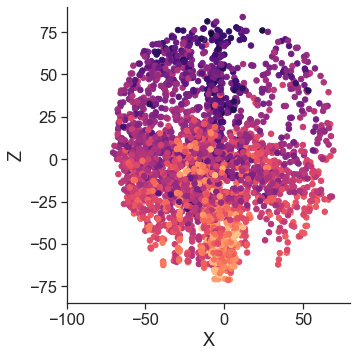

In [139]:
# and the other view

for i in range(pls_mod.y_weights_.shape[0]):
    # colors
    cmap = sns.color_palette(pals[i],as_cmap=True)
    #sg = tfm_X[:,i]
    sg = diff.values[:,i]
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    # decorate
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.ylim(-85,90)
    plt.xlim(-80,80)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.savefig(os.path.join(fig_dir,'brain_plot_DiffC%s_XZ.png'%(i+1)),bbox_inches='tight')



In [30]:
tfm_X.shape

(3466, 3)

In [11]:
gdf.loc[:,'C1_tfm'] = tfm_X[:,0]
gdf.loc[:,'C2_tfm'] = tfm_X[:,1]
gdf.loc[:,'C3_tfm'] = tfm_X[:,2]

# Clustering

In [38]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
d = gdf[['C1_orig','C2_orig','C3_orig']].values

# run hierarchichal agglomerative clustering with k=2-15, and
# save cluster evaluation metrics
csol = pandas.DataFrame()
for i,k in enumerate(range(2,15)):
    print('working on k =',k)
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                  linkage='ward')
    cluster.fit_predict(d)
    csol.loc[i,'k'] = k
    csol.loc[i,'sil_score'] = silhouette_score(d,cluster.labels_,random_state=123)
    csol.loc[i,'ch_score'] = calinski_harabasz_score(d,cluster.labels_)

working on k = 2
working on k = 3
working on k = 4
working on k = 5
working on k = 6
working on k = 7
working on k = 8
working on k = 9
working on k = 10
working on k = 11
working on k = 12
working on k = 13
working on k = 14


[Text(0, 0, '2'),
 Text(1, 0, '3'),
 Text(2, 0, '4'),
 Text(3, 0, '5'),
 Text(4, 0, '6'),
 Text(5, 0, '7'),
 Text(6, 0, '8'),
 Text(7, 0, '9'),
 Text(8, 0, '10'),
 Text(9, 0, '11'),
 Text(10, 0, '12'),
 Text(11, 0, '13'),
 Text(12, 0, '14')]

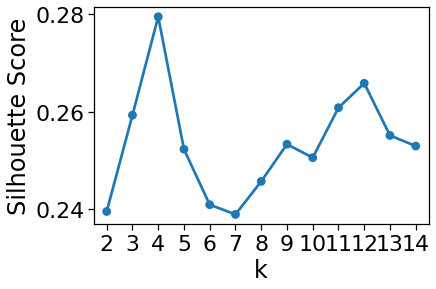

In [43]:
sns.set_context('notebook',font_scale=2)
g=sns.pointplot(x='k',y='sil_score',data=csol)
#plt.text(4,0.36,'k=6\n*',size=15,ha='center')
plt.ylabel('Silhouette Score')
g.set_xticklabels([int(float(x.get_text())) for x in g.get_xticklabels()])
#plt.savefig(os.path.join(fig_dir,'Silhouette.pdf'),bbox_inches='tight')

[Text(0, 0, '2'),
 Text(1, 0, '3'),
 Text(2, 0, '4'),
 Text(3, 0, '5'),
 Text(4, 0, '6'),
 Text(5, 0, '7'),
 Text(6, 0, '8'),
 Text(7, 0, '9'),
 Text(8, 0, '10'),
 Text(9, 0, '11'),
 Text(10, 0, '12'),
 Text(11, 0, '13'),
 Text(12, 0, '14')]

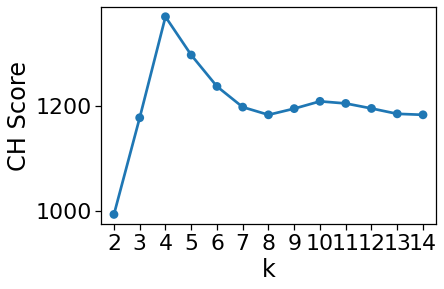

In [41]:
sns.set_context('notebook',font_scale=2)
g=sns.pointplot(x='k',y='ch_score',data=csol)
#plt.text(4,0.36,'k=6\n*',size=15,ha='center')
plt.ylabel('CH Score')
g.set_xticklabels([int(float(x.get_text())) for x in g.get_xticklabels()])
#plt.savefig(os.path.join(fig_dir,'Silhouette.pdf'),bbox_inches='tight')

In [ ]:
cluster.

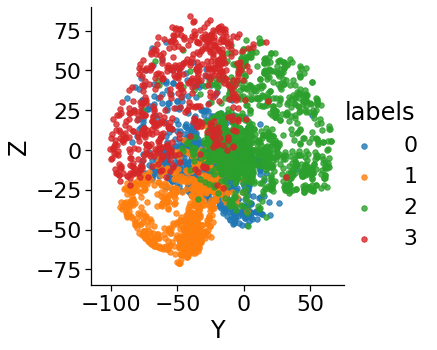

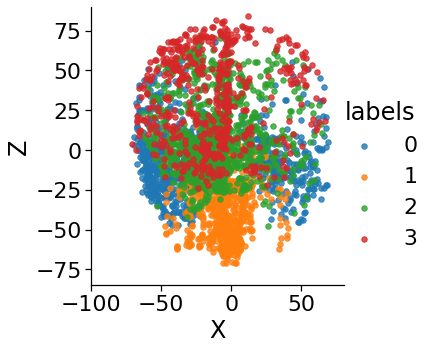

In [47]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', 
                                  linkage='ward')
labels = cluster.fit_predict(d)
gdf.loc[:,'labels'] = labels

# plot
g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
               data=gdf, fit_reg=False,hue='labels', 
               scatter_kws={"s": 30,},#'color':cscale},
              palette='tab10')

# decorate
plt.xlabel('Y')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
plt.xticks([-100,-50,0,50])
plt.yticks(list(range(-75,76,25)))
plt.show() 

g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z',  
               data=gdf, fit_reg=False,hue='labels', 
               scatter_kws={"s": 30,},#'color':cscale},
              palette='tab10')

# decorate
plt.xlabel('X')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-80,80)
plt.xticks([-100,-50,0,50])
plt.yticks(list(range(-75,76,25)))
plt.show() 

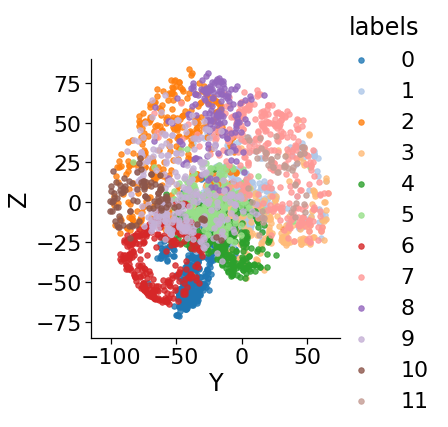

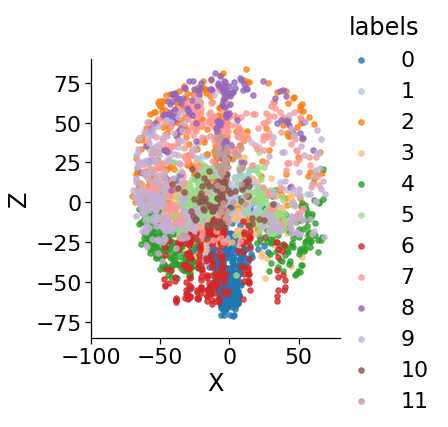

In [50]:
cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')
labels = cluster.fit_predict(d)
gdf.loc[:,'labels'] = labels

# plot
g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
               data=gdf, fit_reg=False,hue='labels', 
               scatter_kws={"s": 30,},#'color':cscale},
              palette='tab20')

# decorate
plt.xlabel('Y')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
plt.xticks([-100,-50,0,50])
plt.yticks(list(range(-75,76,25)))
plt.show() 

g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z',  
               data=gdf, fit_reg=False,hue='labels', 
               scatter_kws={"s": 30,},#'color':cscale},
              palette='tab20')

# decorate
plt.xlabel('X')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-80,80)
plt.xticks([-100,-50,0,50])
plt.yticks(list(range(-75,76,25)))
plt.show() 

# Understanding the components

Here we break down the assign each sample to different anatomical category based on their anatomical label. We will explore the relationship between component expression and anatomical information

#### Sample assignment

In [47]:
# first, assign each sample to larger brain regions

Medulla = ['arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                 'central glial substance',
                 'central medullary reticular group, left','central medullary reticular group, right',
                 'cochlear nuclei, left','cochlear nuclei, right',
                 'cuneate nucleus, left','cuneate nucleus, right',
                 'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right',
                 'gigantocellular group, left','gigantocellular group, right',
                 'gracile nucleus, left','gracile nucleus, right',
                 'hypoglossal nucleus, left','hypoglossal nucleus, right',
                 'inferior olivary complex, left','inferior olivary complex, right',
                 'lateral medullary reticular group, left','lateral medullary reticular group, right',
                 'raphe nuclei of medulla',
                 'spinal trigeminal nucleus, left','spinal trigeminal nucleus, right',
                 'superior olivary complex, left','superior olivary complex, right',
                 'vestibular nuclei, left','vestibular nuclei, right']

Pons =          ['abducens nucleus, left','abducens nucleus, right',
                 'central gray of the pons, left','central gray of the pons, right',
                 'facial motor nucleus, left','facial motor nucleus, right',
                 'lateral parabrachial nucleus, left','lateral parabrachial nucleus, right',
                 'locus ceruleus, left','locus ceruleus, right',
                 'medial parabrachial nucleus, left','medial parabrachial nucleus, right',
                 'medial parabrachial nucleus,right',
                 'motor nucleus of trigeminal nerve, left','motor nucleus of trigeminal nerve, right',
                 'nucleus subceruleus, left','nucleus subceruleus, right',
                 'pontine nuclei, left','pontine nuclei, right',
                 'pontine raphe nucleus','pontine raphe nucleus, left',
                 'pontine reticular formation, left','pontine reticular formation, right',
                 'principal sensory nucleus of trigeminal nerve, left','principal sensory nucleus of trigeminal nerve, right',
                 ]

DCN = ['dentate nucleus, left',
       'dentate nucleus, right',
       'emboliform nucleus, left',
       'emboliform nucleus, right',
       'fastigial nucleus, left',
       'fastigial nucleus, right',
       'globose nucleus, left',
       'globose nucleus, right']

Cerebellum = [x for x in gdf[gdf.slab_type=='CB']['structure_name'].unique().tolist() if x not in DCN]

Tectum = ['inferior colliculus, left',
          'superior colliculus, left','superior colliculus, right',
          'pretectal region']

Tegmentum = ['central gray substance of midbrain, left','central gray substance of midbrain, right',
            'cuneiform nucleus, left','cuneiform nucleus, right',
            'Edinger-Westphal nucleus, left','Edinger-Westphal nucleus, right',
            'interstitial nucleus of Cajal, left','interstitial nucleus of Cajal, right',
            'midbrain raphe nuclei','midbrain raphe nuclei, left',
            'midbrain reticular formation, left','midbrain reticular formation, right',
            'nucleus of Darkschewitsch, left',
            'oculomotor nuclear complex, right','oculomotor nuclear complex, left',
            'red nucleus, left','red nucleus, right',
            'subcuneiform nucleus, left','subcuneiform nucleus, right',
            'substantia nigra, pars compacta, left','substantia nigra, pars compacta, right',
            'substantia nigra, pars reticulata, left','substantia nigra, pars reticulata, right',
            'trochlear nucleus, left','trochlear nucleus, right',
            'ventral tegmental area, left','ventral tegmental area, right']

Hypothalamus = ['anterior hypothalamic area, left','anterior hypothalamic area, right',
               'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
               'dorsomedial hypothalamic nucleus, left',
               'lateral hypothalamic area, anterior region, left', 'lateral hypothalamic area, anterior region, right',
               'lateral hypothalamic area, mammillary region, left', 'lateral hypothalamic area, mammillary region, right',
               'lateral hypothalamic area, tuberal region, left',
               'paraventricular nucleus of the hypothalamus, left','paraventricular nucleus of the hypothalamus, right',
               'perifornical nucleus, left',
               'posterior hypothalamic area, left','posterior hypothalamic area, right',
               'preoptic region, left','preoptic region, right',
               'supraoptic nucleus, left','supraoptic nucleus, right',
               'ventromedial hypothalamic nucleus, left','ventromedial hypothalamic nucleus, right',]
                

Thalamus = ['anterior group of nuclei, left','anterior group of nuclei, right',
           'caudal group of intralaminar nuclei, left','caudal group of intralaminar nuclei, right',
           'dorsal lateral geniculate nucleus, left','dorsal lateral geniculate nucleus, right',
           'lateral group of nuclei, left, dorsal division','lateral group of nuclei, left, ventral division',
           'lateral group of nuclei, right, dorsal division','lateral group of nuclei, right, ventral division',
           'medial geniculate complex, left','medial geniculate complex, right',
           'medial group of nuclei, left','medial group of nuclei, right',
           'reticular nucleus of thalamus, left','reticular nucleus of thalamus, right',
           'rostral group of intralaminar nuclei, left','rostral group of intralaminar nuclei, right',
           'paraventricular nuclei, left of thalamus, left','paraventricular nuclei, right of thalamus, right',
           'posterior group of nuclei, left','posterior group of nuclei, right',
           'subthalamic nucleus, left','subthalamic nucleus, right',
           'zona incerta, left','zona incerta, right']

Other_Dien = ['lateral habenular nucleus, left','lateral habenular nucleus, right',
             'lateral mammillary nucleus, left',
             'lateral tuberal nucleus, left',
             'mammillary body, left','mammillary body, right',
             'medial habenular nucleus, left','medial habenular nucleus, right',
             'medial mammillary nucleus, left',
             'pallidohypothalamic nucleus, left',
             'pineal gland',
             'supramammillary nucleus, left',
             'tuberomammillary nucleus, left']

Limbic = ['CA1 field, left','CA1 field, right',
          'CA2 field, left','CA2 field, right',
          'CA3 field, left','CA3 field, right',
          'CA4 field, left','CA4 field, right',
          'amygdalohippocampal transition zone, left',
          'amygdalohippocampal transition zone, right',
          'basolateral nucleus, left','basolateral nucleus, right',
          'basomedial nucleus, left','basomedial nucleus, right',
          'central nucleus, left','central nucleus, right',
          'cortico-medial group, left','cortico-medial group, right',
          'dentate gyrus, left','dentate gyrus, right',
          'lateral nucleus, left','lateral nucleus, right',
          'septal nuclei, left','septal nuclei, right',
         'subiculum, left','subiculum, right']

Forebrain = ['basal nucleus of meynert, left','basal nucleus of meynert, right',
            'nucleus accumbens, left','nucleus accumbens, right',
            'nucleus of the diagonal band, left, horizontal division',
            'nucleus of the diagonal band, left, vertical division',
            'olfactory tubercle, left', 'piriform cortex, left',
            'substantia innominata, left','substantia innominata, right']

Striatum = ['bed  nucleus of stria terminalis, left',
            'body of caudate nucleus, left',
            'body of caudate nucleus, right',
            'globus pallidus, external segment, left','globus pallidus, external segment, right',
            'globus pallidus, internal segment, left','globus pallidus, internal segment, right',
            'head of caudate nucleus, left','head of caudate nucleus, right',
            'olfactory tubercle, left',
            'putamen, left','putamen, right',
           'tail of caudate nucleus, left','tail of caudate nucleus, right']

Anterior_Cingulate = ['cingulate gyrus, frontal part, left, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, left, superior bank of gyrus',
                     'cingulate gyrus, frontal part, right, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, right, superior bank of gyrus',
                     'paraterminal gyrus, right',
                     'parolfactory gyri, left','parolfactory gyri, right',
                     'subcallosal cingulate gyrus, left','subcallosal cingulate gyrus, right']

Posterior_Cingulate = ['cingulate gyrus, parietal part, left, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, left, superior bank of gyrus',
                     'cingulate gyrus, parietal part, right, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, right, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, superior bank of gyrus',]

Insula = ['claustrum, left','claustrum, right',
         'long insular gyri, left','long insular gyri, right',
         'short insular gyri, left','short insular gyri, right',]

Temporal = ["Heschl's gyrus, left", "Heschl's gyrus, right",
           'fusiform gyrus, left, bank of cos','fusiform gyrus, left, bank of the its',
           'fusiform gyrus, left, lateral bank of gyrus','fusiform gyrus, right, bank of cos',
           'fusiform gyrus, right, bank of the its','fusiform gyrus, right, lateral bank of gyrus',
           'inferior temporal gyrus, left, bank of mts','inferior temporal gyrus, left, bank of the its',
           'inferior temporal gyrus, left, lateral bank of gyrus','inferior temporal gyrus, right, bank of mts',
           'inferior temporal gyrus, right, bank of the its','inferior temporal gyrus, right, lateral bank of gyrus',
           'middle temporal gyrus, left, inferior bank of gyrus','middle temporal gyrus, left, superior bank of gyrus',
           'middle temporal gyrus, right, inferior bank of gyrus','middle temporal gyrus, right, superior bank of gyrus',
           'occipito-temporal gyrus, left, inferior bank of gyrus','occipito-temporal gyrus, left, superior bank of gyrus',
           'occipito-temporal gyrus, right, inferior bank of gyrus','occipito-temporal gyrus, right, superior bank of gyrus',
           'parahippocampal gyrus, left, bank of the cos','parahippocampal gyrus, left, lateral bank of gyrus',
           'parahippocampal gyrus, right, bank of the cos','parahippocampal gyrus, right, lateral bank of gyrus',
           'superior temporal gyrus, left, inferior bank of gyrus','superior temporal gyrus, left, lateral bank of gyrus',
           'superior temporal gyrus, right, inferior bank of gyrus','superior temporal gyrus, right, lateral bank of gyrus',
           'temporal pole, left, inferior aspect','temporal pole, left, medial aspect',
           'temporal pole, left, superior aspect','temporal pole, right, inferior aspect',
           'temporal pole, right, medial aspect','temporal pole, right, superior aspect',
           'transverse gyri, left','transverse gyri, right',
           'planum polare, left','planum polare, right',
           'planum temporale, left','planum temporale, right']

Parietal = ['angular gyrus, left, inferior bank of gyrus','angular gyrus, left, superior bank of gyrus',
            'angular gyrus, right, inferior bank of gyrus','angular gyrus, right, superior bank of gyrus',
            'precuneus, left, inferior lateral bank of gyrus','precuneus, left, superior lateral bank of gyrus',
            'precuneus, right, inferior lateral bank of gyrus','precuneus, right, superior lateral bank of gyrus',
            'superior parietal lobule, left, inferior bank of gyrus','superior parietal lobule, left, superior bank of gyrus',
            'superior parietal lobule, right, inferior bank of gyrus','superior parietal lobule, right, superior bank of gyrus',
            'supramarginal gyrus, left, inferior bank of gyrus','supramarginal gyrus, left, superior bank of gyrus',
            'supramarginal gyrus, right, inferior bank of gyrus','supramarginal gyrus, right, superior bank of gyrus']

Frontal = ['anterior orbital gyrus, left','anterior orbital gyrus, right',
           'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
          'frontal operculum, left','frontal operculum, right',
          'frontal pole, left, inferior aspect','frontal pole, left, medial aspect',
          'frontal pole, left, superior aspect','frontal pole, right, inferior aspect',
          'frontal pole, right, medial aspect','frontal pole, right, superior aspect',
          'gyrus rectus, left','gyrus rectus, right',
          'inferior frontal gyrus, opercular part, left','inferior frontal gyrus, opercular part, right',
          'inferior frontal gyrus, orbital part, left','inferior frontal gyrus, orbital part, right',
          'inferior frontal gyrus, triangular part, left','inferior frontal gyrus, triangular part, right',
          'inferior rostral gyrus, left','inferior rostral gyrus, right',
          'lateral orbital gyrus, left','lateral orbital gyrus, right',
          'medial orbital gyrus, left','medial orbital gyrus, right',
          'middle frontal gyrus, left, inferior bank of gyrus','middle frontal gyrus, left, superior bank of gyrus',
          'middle frontal gyrus, right, inferior bank of gyrus','middle frontal gyrus, right, superior bank of gyrus',
          'posterior orbital gyrus, left','posterior orbital gyrus, right',
          'superior frontal gyrus, left','superior frontal gyrus, left, lateral bank of gyrus',
          'superior frontal gyrus, left, medial bank of gyrus','superior frontal gyrus, right, lateral bank of gyrus',
          'superior frontal gyrus, right, medial bank of gyrus',
          'superior rostral gyrus, left','superior rostral gyrus, right']

Occipital = ['cuneus, left, peristriate',
             'cuneus, left, striate',
             'cuneus, right, peristriate',
             'cuneus, right, striate',
             'inferior occipital gyrus, left, inferior bank of gyrus','inferior occipital gyrus, left, superior bank of gyrus',
             'inferior occipital gyrus, right, inferior bank of gyrus','inferior occipital gyrus, right, superior bank of gyrus',
             'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
             'lingual gyrus, right, peristriate','lingual gyrus, right, striate',
             'occipital pole, left, inferior aspect',
             'occipital pole, left, lateral aspect','occipital pole, left, superior aspect',
             'superior occipital gyrus, left, inferior bank of gyrus','superior occipital gyrus, left, superior bank of gyrus',
             'superior occipital gyrus, right, inferior bank of gyrus','superior occipital gyrus, right, superior bank of gyrus',]

Sensorimotor = ['paracentral lobule, anterior part, left','paracentral lobule, anterior part, left, inferior bank of gyrus',
                'paracentral lobule, anterior part, left, superior bank of gyrus','paracentral lobule, anterior part, right, inferior bank of gyrus',
                'paracentral lobule, anterior part, right, superior bank of gyrus','paracentral lobule, posterior part, left, bank of cingulate sulcus',
                'paracentral lobule, posterior part, left, lateral bank of gyrus','paracentral lobule, posterior part, right, bank of cingulate sulcus',
                'paracentral lobule, posterior part, right, lateral bank of gyrus',
                'postcentral gyrus, left, bank of the central sulcus','postcentral gyrus, left, bank of the posterior central sulcus',
                'postcentral gyrus, left, inferior lateral aspect of gyrus','postcentral gyrus, left, superior lateral aspect of gyrus',
                'postcentral gyrus, right, bank of the central sulcus','postcentral gyrus, right, bank of the posterior central sulcus',
                'postcentral gyrus, right, inferior lateral aspect of gyrus','postcentral gyrus, right, superior lateral aspect of gyrus',
                'precentral gyrus, left, bank of the central sulcus','precentral gyrus, left, bank of the precentral sulcus',
                'precentral gyrus, left, inferior lateral aspect of gyrus','precentral gyrus, left, superior lateral aspect of gyrus',
                'precentral gyrus, right, bank of the central sulcus','precentral gyrus, right, bank of the precentral sulcus',
                'precentral gyrus, right, inferior lateral aspect of gyrus','precentral gyrus, right, superior lateral aspect of gyrus']
            
divs = [Medulla, Pons, DCN, Cerebellum, Tectum, Tegmentum, Hypothalamus, Thalamus, Other_Dien,
                  Limbic, Forebrain, Striatum, Anterior_Cingulate, Posterior_Cingulate, Insula,
                  Temporal, Frontal, Parietal, Occipital, Sensorimotor]
names = ['Medulla', 'Pons', 'DCN', 'Cerebellum', 'Tectum', 'Tegmentum', 'Hypothalamus', 'Thalamus', 
         'Other_Dien', 'Limbic', 'Forebrain', 'Striatum', 'Anterior_Cingulate', 'Posterior_Cingulate', 
         'Insula', 'Temporal', 'Frontal', 'Parietal', 'Occipital', 'Sensorimotor']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'brain_divison'] = name
    

In [48]:
# For C1 -- which segment of the neural tube does the region originate from
Meyelencephalon = Medulla[:] 
Metencelphalon = Pons + DCN + Cerebellum
Mesencephalon = Tectum + Tegmentum
Diencephalon = Hypothalamus + Thalamus + Other_Dien
Telencephalon = Limbic + Forebrain + Striatum + Anterior_Cingulate + Posterior_Cingulate +\
                Insula + Temporal + Frontal + Parietal + Occipital + Sensorimotor

divs = [Meyelencephalon, Metencelphalon, Mesencephalon, Diencephalon, Telencephalon]
names = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 'Diencephalon', 'Telencephalon']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'Neural_Tube_segment'] = name
    

In [49]:
# For C3 -- what kind of cortex does the sample belong to

Auditory = ["Heschl's gyrus, left", "Heschl's gyrus, right",
            'planum polare, left','planum polare, right',
            'planum temporale, left','planum temporale, right',
            'transverse gyri, left','transverse gyri, right']
Visual = ['cuneus, left, peristriate','cuneus, left, striate',
                 'cuneus, right, peristriate','cuneus, right, striate',
                 'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
                 'lingual gyrus, right, peristriate','lingual gyrus, right, striate']
Olfactory = ['olfactory tubercle, left', 'piriform cortex, left']


Sensory_Cortex = Sensorimotor + Auditory + Visual + Olfactory
gdf.loc[gdf[gdf.structure_name.isin(Sensory_Cortex)].index,'Cortical_Type'] = 'Sensory'

Association_Cortex = [x for x in Telencephalon if x not in Striatum and x not in Sensory_Cortex]
gdf.loc[gdf[gdf.structure_name.isin(Association_Cortex)].index,'Cortical_Type'] = 'Association_Cortex'

Cerebellar_Cortex = [x for x in Cerebellum]
gdf.loc[gdf[gdf.structure_name.isin(Cerebellar_Cortex)].index,'Cortical_Type'] = 'Cerebellar_Cortex'

Not_Cortex = Meyelencephalon + Mesencephalon + Pons + DCN + Diencephalon + Striatum
gdf.loc[gdf[gdf.structure_name.isin(Not_Cortex)].index,'Cortical_Type'] = 'Not Cortex'


divs = [Auditory, Visual, Olfactory, Sensorimotor, Association_Cortex, Not_Cortex, Cerebellar_Cortex]
names = ['Auditory','Visual','Olfactory','Sensorimotor','Association_Cortex','Not_Cortex','Cerebellar_Cortex']
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'Sensory_Type'] = name


In [50]:
# for c2 -- does the sample's region originate from the dorsal or ventral aspect of the neural tube
alar_medulla = ['spinal trigeminal nucleus, right', 'spinal trigeminal nucleus, left',
               'cochlear nuclei, left','cochlear nuclei, right',
               'vestibular nuclei, left','vestibular nuclei, right',
               'inferior olivary complex, left','inferior olivary complex, right',
                'gracile nucleus, left','gracile nucleus, right',
               'cuneate nucleus, left','cuneate nucleus, right',
               'superior olivary complex, left','superior olivary complex, right',]

basal_medulla = ['hypoglossal nucleus, left','hypoglossal nucleus, right',
                'lateral medullary reticular group, left','lateral medullary reticular group, right',
                'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right', 
                'arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                'central medullary reticular group, left','central medullary reticular group, right',
                'raphe nuclei of medulla',
                'gigantocellular group, left','gigantocellular group, right', ]


divs = [alar_medulla, basal_medulla]
names = ['Alar_Medulla','Basal_Medulla']
med_division = dict(zip(names,divs))

for name, div in med_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'brain_divison'] = name

dorsal_plate = ['Cerebellum', 'Thalamus', 'Tectum', 'Alar_Medulla']
ventral_plate = ['Hypothalamus','Pons','Tegmentum','Basal_Medulla']
subcortical = ['Forebrain', 'Striatum', 'Limbic']
frontal = ['Anterior_Cingulate','Insula','Frintal']
temporal = ['Temporal']
somatomotor = ['Sensorimotor']
parietal = ['Parietal']
occipital = ['Occipital']

gdf.loc[gdf[gdf.brain_divison.isin(dorsal_plate)].index,'Neural_Plate'] = 'Dorsal'
gdf.loc[gdf[gdf.brain_divison.isin(ventral_plate)].index,'Neural_Plate'] = 'Ventral'
gdf.loc[gdf[gdf.brain_divison.isin(subcortical)].index,'Neural_Plate'] = 'Subcortical'
gdf.loc[gdf[gdf.brain_divison.isin(frontal)].index,'Neural_Plate'] = 'Frontal'
gdf.loc[gdf[gdf.brain_divison.isin(temporal)].index,'Neural_Plate'] = 'Temporal'
gdf.loc[gdf[gdf.brain_divison.isin(somatomotor)].index,'Neural_Plate'] = 'Somatomotor'
gdf.loc[gdf[gdf.brain_divison.isin(parietal)].index,'Neural_Plate'] = 'Parietal'
gdf.loc[gdf[gdf.brain_divison.isin(occipital)].index,'Neural_Plate'] = 'Occipital'


In [51]:
# for GTeX

gfrontal = Frontal
gAC = Anterior_Cingulate
gCereb = Cerebellum
gHT = Hypothalamus
gCaud = ['body of caudate nucleus, left',
         'body of caudate nucleus, right',
        'head of caudate nucleus, left',
         'head of caudate nucleus, right',
        'tail of caudate nucleus, left',
         'tail of caudate nucleus, right']
gPut = ['putamen, left','putamen, right',]
gGP = ['globus pallidus, external segment, left',
       'globus pallidus, external segment, right',
       'globus pallidus, internal segment, left',
       'globus pallidus, internal segment, right',]
gAmyg = ['basolateral nucleus, left','basolateral nucleus, right',
          'basomedial nucleus, left','basomedial nucleus, right',
          'central nucleus, left','central nucleus, right',
          'cortico-medial group, left','cortico-medial group, right',
        'lateral nucleus, left','lateral nucleus, right']
gHipp = ['CA1 field, left','CA1 field, right',
          'CA2 field, left','CA2 field, right',
          'CA3 field, left','CA3 field, right',
          'CA4 field, left','CA4 field, right',
         'dentate gyrus, left','dentate gyrus, right',
        'subiculum, left','subiculum, right']
sn = ['substantia nigra, pars compacta, left',
      'substantia nigra, pars compacta, right',
      'substantia nigra, pars reticulata, left',
      'substantia nigra, pars reticulata, right']
gNAcc = ['nucleus accumbens, left','nucleus accumbens, right',]

divs = [gfrontal, gAC, gCereb, gHT, gCaud, gPut, gGP, gAmyg, 
        gHipp,sn,gNAcc]
names = ['Frontal', 'AntCing', 'Cerebellum', 'Hypothalamus', 
         'Caudate','Putamen','Pallidum','Amygdala','Hippocampus',
        'Nigra','Accumbens']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'GTeX_div'] = name
    

In [45]:
tfm_X,tfm_Y = pls_mod.transform(pca_tfm, full_y)
gdf.loc[:,'C1_orig'] = tfm_X[:,0]
gdf.loc[:,'C2_orig'] = tfm_X[:,1]
gdf.loc[:,'C3_orig'] = tfm_X[:,2]

In [55]:
gdf.loc[:,'C1_Expression'] = tfm_X[:,0]
gdf.loc[:,'C2_Expression'] = tfm_X[:,1]
gdf.loc[:,'C3_Expression'] = tfm_X[:,2]

#### Plotting associations

In [17]:
gdf.to_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/gdf_w_CompExp_rotated.csv')

In [48]:
fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/PostFix/subfigs/'

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 15.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


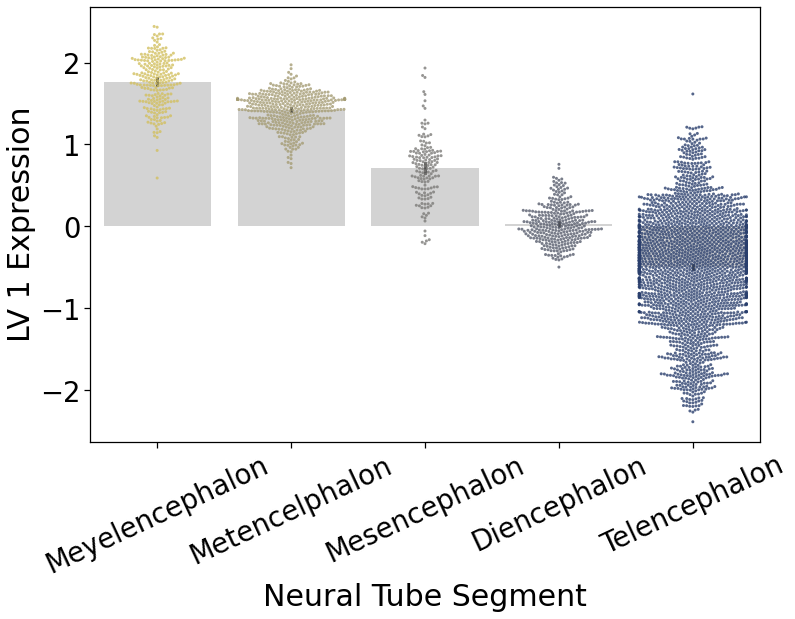

In [56]:
# C1
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 
         'Diencephalon', 'Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='C1_Expression', 
            data=gdf,color='lightgray',
           order = order)
g=sns.swarmplot(x='Neural_Tube_segment', y='C1_Expression', 
              data=gdf, size=3,alpha=0.8,
              order = order, palette='cividis_r')
g.set_xticklabels(order,rotation=25)
plt.xlabel('Neural Tube Segment')
plt.ylabel('LV 1 Expression')
plt.savefig(os.path.join(fig_dir,'C1_NT.png'),bbox_inches='tight')

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


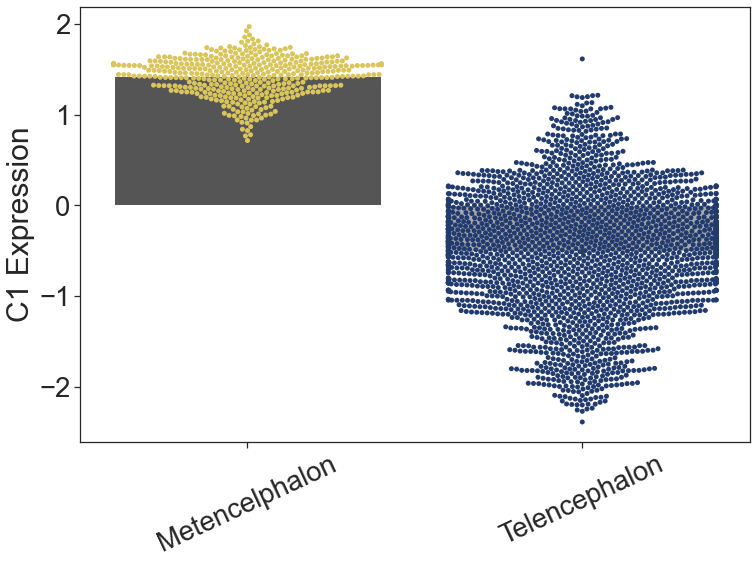

In [67]:
# Just cortex and cerebellum
rbpal = [sns.color_palette('cividis')[-1],
                      sns.color_palette('cividis')[0]]
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Metencelphalon','Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='C1_Expression', 
            data=gdf[gdf.Neural_Tube_segment.isin(order)],
            palette='gray',
           order = order
           )
g=sns.swarmplot(x='Neural_Tube_segment', y='C1_Expression', 
              data=gdf[gdf.Neural_Tube_segment.isin(order)], 
              order = order, palette=rbpal)
g.set_xticklabels(order,rotation=25)
plt.ylabel('C1 Expression')
plt.xlabel('')
plt.savefig(os.path.join(fig_dir,'BSComp_ABA_C1.png'),bbox_inches='tight')


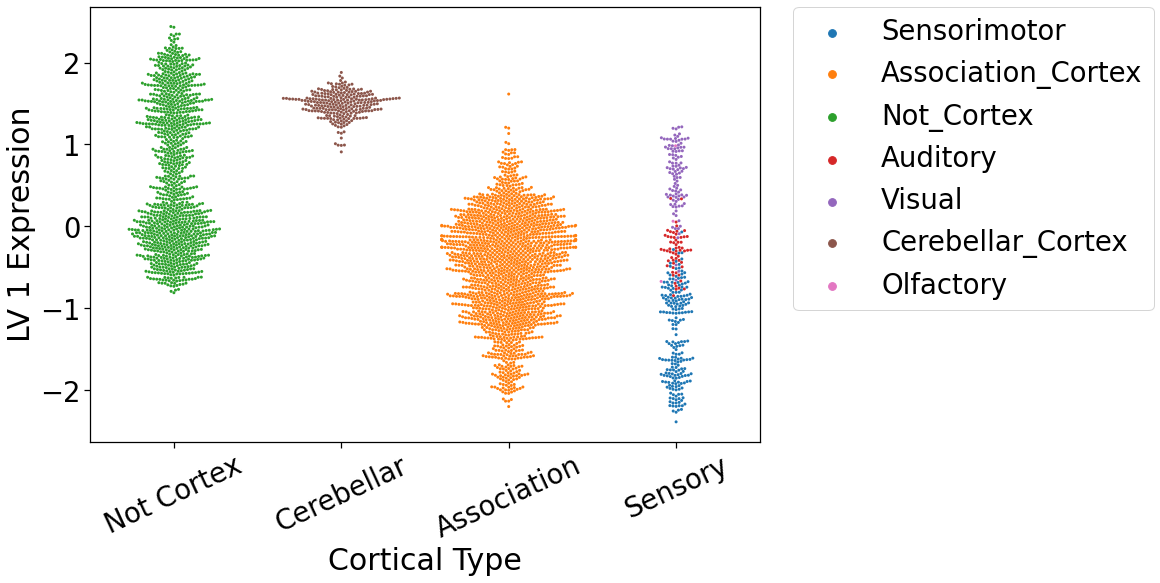

In [67]:
# C1 Cortical types
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Cerebellar_Cortex','Association_Cortex','Sensory']
g=sns.swarmplot(x='Cortical_Type', y='C1_Expression', data=gdf, size=3,
                hue='Sensory_Type', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Not Cortex','Cerebellar','Association','Sensory'],
                  rotation=25)
plt.xlabel('Cortical Type')
plt.ylabel('LV 1 Expression')
plt.savefig(os.path.join(fig_dir,'C1_Modals.pdf'),bbox_inches='tight')

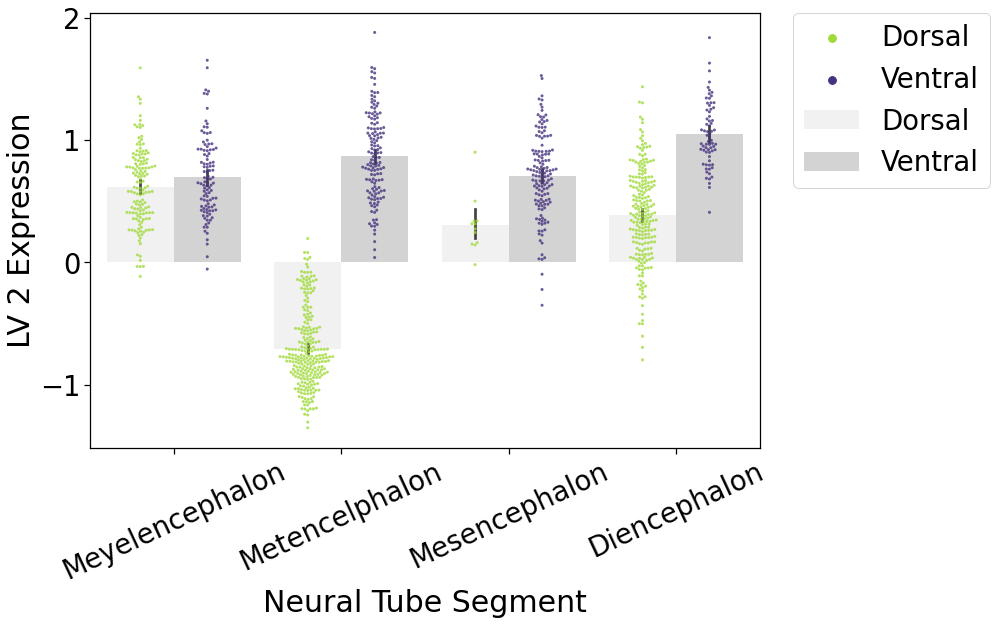

In [66]:
# C2
rbpal = [sns.color_palette('viridis')[-1],
                      sns.color_palette('viridis')[0]]
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 
         'Diencephalon']
horder = ['Dorsal','Ventral']
sns.barplot(x='Neural_Tube_segment', y='C2_Expression', 
            data=gdf[gdf.Neural_Tube_segment!='Telencephalon'],
            color='lightgray',hue='Neural_Plate',
           order = order,hue_order=horder)
g=sns.swarmplot(x='Neural_Tube_segment', y='C2_Expression', 
              data=gdf[gdf.Neural_Tube_segment!='Telencephalon'],
                hue='Neural_Plate',dodge=True,size=3,alpha=0.8,
              order = order, palette=rbpal,hue_order=horder,
               )
plt.ylabel('LV 2 Expression')
plt.xlabel('Neural Tube Segment')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(order,rotation=25)
plt.savefig(os.path.join(fig_dir,'C2_NT-NoTele.pdf'),bbox_inches='tight')

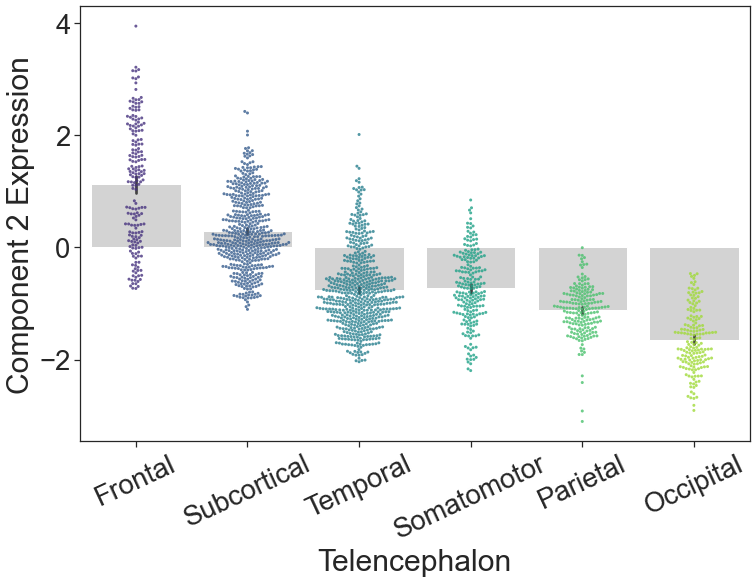

In [56]:
# C2
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Frontal','Subcortical', 'Temporal','Somatomotor', 
         'Parietal','Occipital']
sns.barplot(x='Neural_Plate', y='C2_Expression', 
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
            color='lightgray',
           order = order,
            hue_order=order
           )
g=sns.swarmplot(x='Neural_Plate', y='C2_Expression', 
              data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
              order = order, size=3,
                palette='viridis',alpha=0.8)
g.set_xticklabels(order,rotation=25)
plt.xlabel('Telencephalon')
plt.ylabel('Component 2 Expression')
plt.savefig(os.path.join(fig_dir,'C2_NT-TeleOnly.png'),bbox_inches='tight')

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


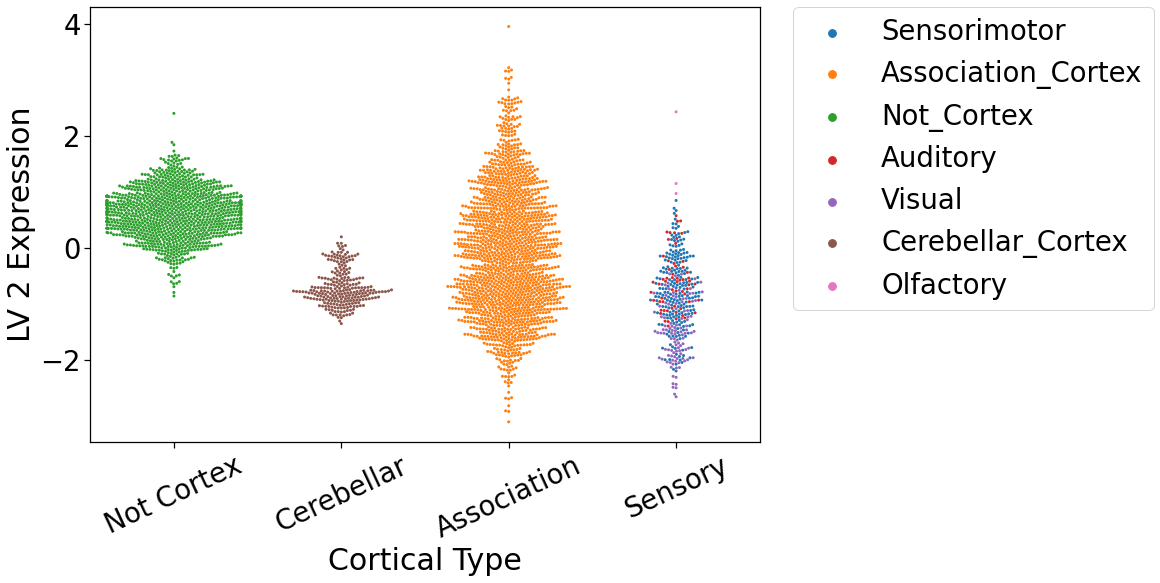

In [59]:
# C2 Cortical types
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Cerebellar_Cortex','Association_Cortex','Sensory']
g=sns.swarmplot(x='Cortical_Type', y='C2_Expression', data=gdf, size=3,
                hue='Sensory_Type', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Not Cortex','Cerebellar','Association','Sensory'],
                  rotation=25)
plt.xlabel('Cortical Type')
plt.ylabel('LV 2 Expression')
plt.savefig(os.path.join(fig_dir,'C2_Modals.pdf'),bbox_inches='tight')

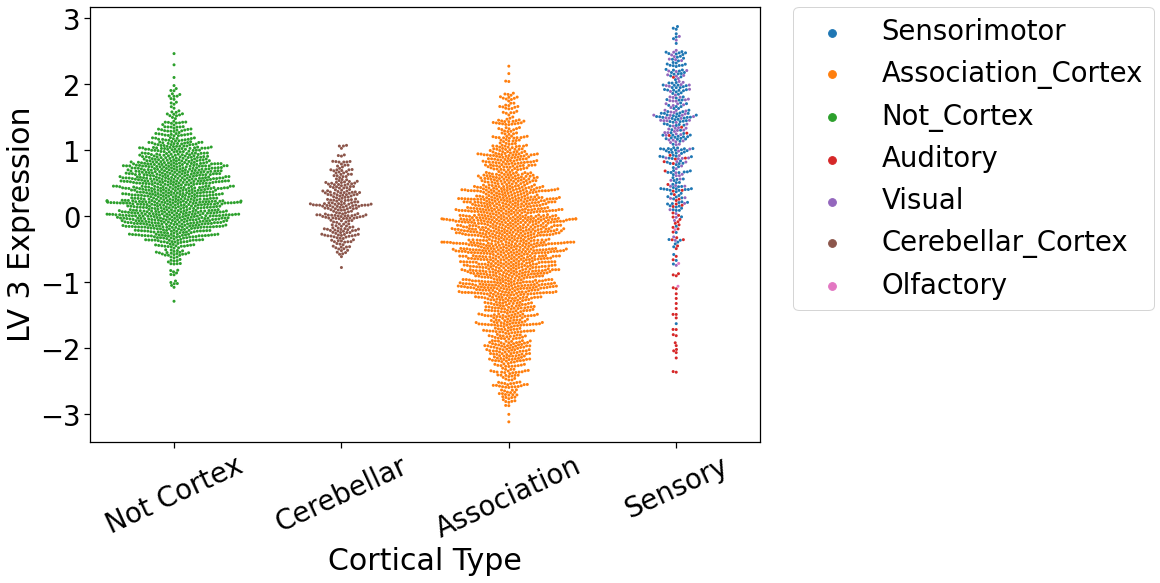

In [60]:
# C3 Cortical types
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Cerebellar_Cortex','Association_Cortex','Sensory']
g = sns.swarmplot(x='Cortical_Type', y='C3_Expression',size=3, 
              data=gdf, hue='Sensory_Type',order=order,
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Not Cortex','Cerebellar','Association','Sensory'],
                  rotation=25)
plt.xlabel('Cortical Type')
plt.ylabel('LV 3 Expression')
plt.savefig(os.path.join(fig_dir,'C3_Modals.pdf'), bbox_inches='tight')

In [132]:
gdf[~gdf.Cortical_Type.isin(['Association_Cortex','Sensory'])]['C1_Expression'].std()

0.8518414675384368

In [1]:
gdf.Cortical_Type.value_counts()

NameError: name 'gdf' is not defined

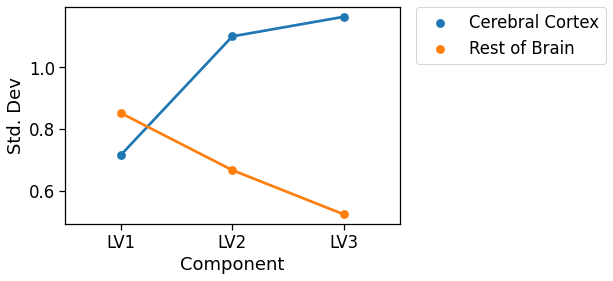

In [61]:
sns.set_context('notebook',font_scale=1.5)
vardf = pandas.DataFrame()
i = 0
for c in range(1,4):
    vardf.loc[i,'Component'] = 'LV%s'%c
    vardf.loc[i,'Region'] = 'Cerebral Cortex'
    vardf.loc[i,'Std. Dev'] = gdf[gdf.Cortical_Type.isin(['Association_Cortex','Sensory'])
                                 ]['C%s_orig'%c].std()
    i += 1
    vardf.loc[i,'Component'] = 'LV%s'%c
    vardf.loc[i,'Region'] = 'Rest of Brain'
    vardf.loc[i,'Std. Dev'] = gdf[~gdf.Cortical_Type.isin(['Association_Cortex','Sensory'])
                                 ]['C%s_orig'%c].std()
    i += 1

sns.pointplot(data=vardf,x='Component',y='Std. Dev',hue='Region')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/PostFix/subfigs/CorticalVariance.pdf',
           bbox_inches='tight')

# Save data for other notebooks

#### Data for Brainspan and GTex validation
Here we are calculating component expression for each major brain division, for each component

In [74]:
for i in range(1,4):
    c_vals = pandas.pivot_table(gdf,values='C%s_Expression'%i,
                                 index='brain_divison',aggfunc=np.mean
                                )
    for div in c_vals.index:
        sem = gdf[gdf.brain_divison==div]['C%s_Expression'%i
                                         ].sem()
        c_vals.loc[div,'sem'] = sem
    c_vals.to_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%i)


In [75]:
c_vals

C3_Expression       sem
brain_divison                               
Alar_Medulla             -0.040422  0.034707
Anterior_Cingulate        0.399308  0.073941
Basal_Medulla             0.164095  0.034545
Cerebellum                0.147776  0.023810
DCN                       0.672513  0.050313
Forebrain                 0.048828  0.082969
Frontal                  -0.335540  0.035365
Hypothalamus              0.536429  0.059657
Insula                   -0.883416  0.062767
Limbic                   -0.298623  0.045428
Occipital                 1.016069  0.065534
Other_Dien                0.192768  0.098537
Parietal                  0.293489  0.045920
Pons                      0.249110  0.030594
Posterior_Cingulate       0.779548  0.092527
Sensorimotor              1.253208  0.056368
Striatum                  0.012065  0.026148
Tectum                    0.573886  0.084059
Tegmentum                 0.637294  0.038881
Temporal                 -1.284152  0.038003
Thalamus                  0.864861  0.032991

In [76]:
### same thing for GTeX
for i in range(1,4):
    c_vals = pandas.pivot_table(gdf,values='C%s_Expression'%i,
                                 index='GTeX_div',aggfunc=np.mean
                                )
    for div in c_vals.index:
        sem = gdf[gdf.GTeX_div==div]['C%s_Expression'%i
                                         ].sem()
        c_vals.loc[div,'sem'] = sem
    c_vals.to_csv('data/GCorr_GTexComp_ABA_C%s_data_ROTATION.csv'%i)


#### Supp table

In [100]:
cols = ['donor', 'sample', 'structure_id', 'slab_num', 'well_id', 'slab_type',
       'structure_acronym', 'structure_name','brain_divison','Neural_Tube_segment', 'Cortical_Type',
       'Sensory_Type', 'Neural_Plate', 'GTeX_div']

In [102]:
gdf[cols].to_csv('./tables/structure_labels.csv')

#### PCs
This data is for the XSpecies notebook

In [15]:
pca_tfm.shape

(3466, 100)

In [16]:
gdf.shape

(3466, 39)

In [48]:
allpcs = []
for pc in range(pca_tfm.shape[1]):
    gdf.loc[:,'PC'] = pca_tfm.loc[:,pc]
    c_vals = pandas.pivot_table(gdf,values='PC',
                                 index='brain_divison',aggfunc=np.mean
                                )
    c_vals.columns = ['PC%s'%pc]
    allpcs.append(c_vals)
allpcs = pandas.concat(allpcs,axis=1)

In [50]:
allpcs.to_csv('./data/Allen_Macrostructure_PCs.csv')

In [56]:
compmat = pandas.DataFrame(pcamod.components_,
                           index = ['C%s'%x for x in range(len(pcamod.components_))],
                           columns = bigdf.columns).T

In [58]:
compmat.to_csv('./data/Allen_PC_matrix.csv')

In [180]:
pcamod.components_.shape

(100, 15633)

# Layers

In [51]:
jnk = pandas.ExcelFile('/Users/jacobv/Downloads/41593_2020_787_MOESM3_ESM.xlsx')

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [92]:
p1 = jnk.parse('Table S4B')
p1genes = {}
for i in range(1,7):
    p1genes.update({'L%s'%i:p1[p1['fdr_Layer%s'%i]<0.008333]['gene'].values})


In [113]:
gdf.Cortical_Type.value_counts()

Association_Cortex    1725
Not Cortex            1098
Sensory                385
Cerebellar_Cortex      256
Name: Cortical_Type, dtype: int64

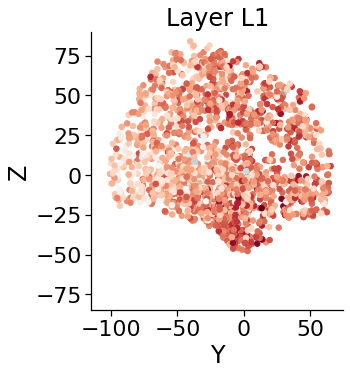

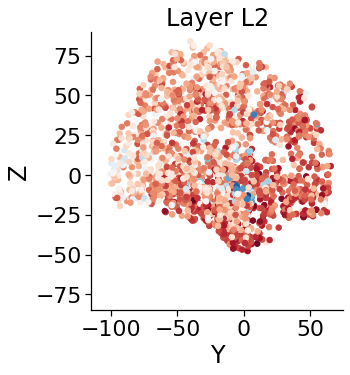

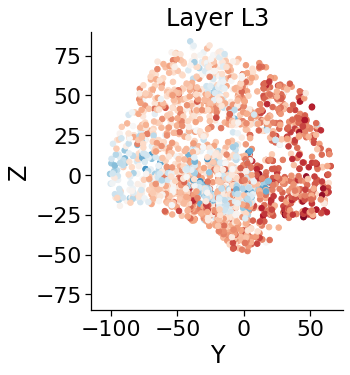

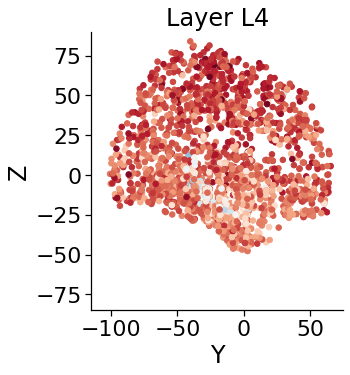

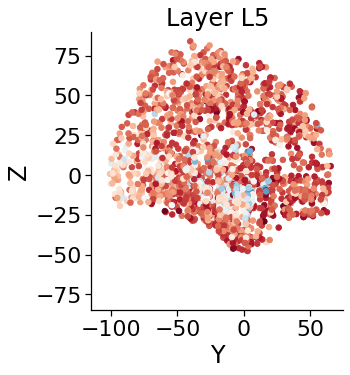

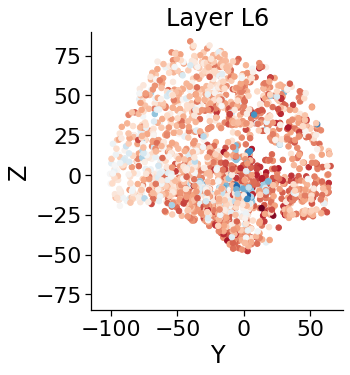

In [115]:
for layer,genes in p1genes.items():
# colors
    cmap = sns.color_palette('RdBu_r',as_cmap=True)
    #sg = tfm_X[:,i]
    shared = list(set(genes) & set(bigdf.columns))
    sg = bigdf.loc[gdf[gdf.Cortical_Type.isin(['Association_Cortex',
                                              'Sensory'])].index,shared].mean(1).values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf[gdf.Cortical_Type.isin(['Association_Cortex',
                                              'Sensory'])], 
                   fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  )
    
    # decorate
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('Layer %s'%layer)
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.show()

In [124]:
p2 = pandas.ExcelFile('/Users/jacobv/Downloads/41593_2017_BFnn4548_MOESM255_ESM.xlsx'
                     ).parse('Sheet1')

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [126]:
p2['Layer marker in human'].value_counts()

L6    2159
L1     772
L2     483
L4     308
L3     294
L5     115
Name: Layer marker in human, dtype: int64

In [130]:
p2genes = {}
for i in range(1,7):
    p2genes.update({'L%s'%i:p2[p2['Layer marker in human']=='L%s'%i]['Gene symbol'].values})

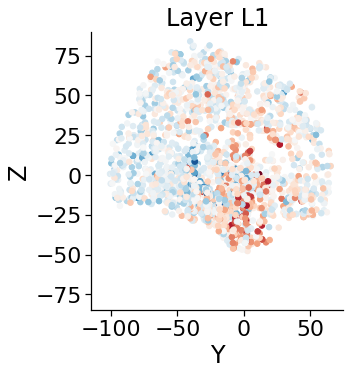

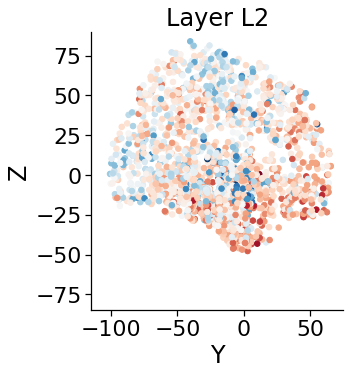

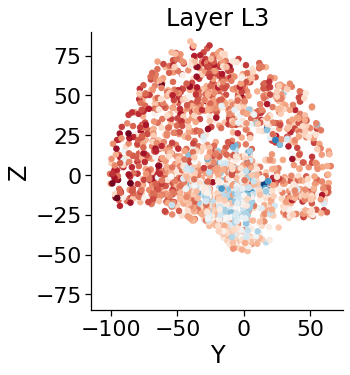

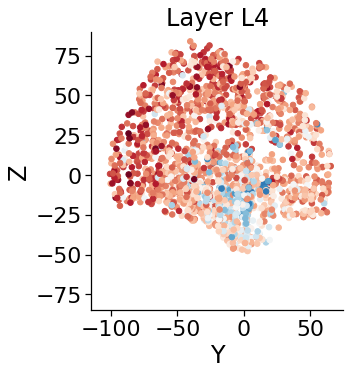

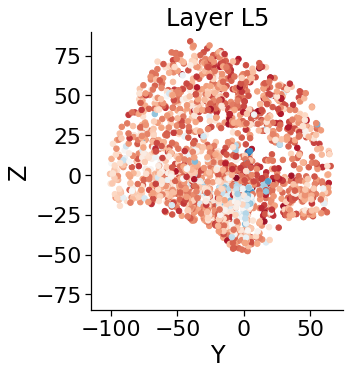

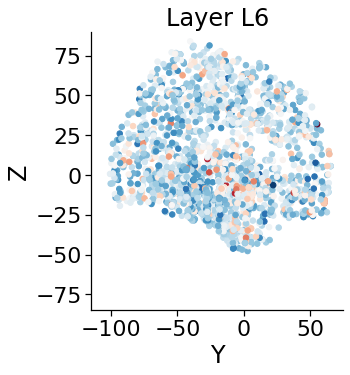

In [131]:
for layer,genes in p2genes.items():
# colors
    cmap = sns.color_palette('RdBu_r',as_cmap=True)
    #sg = tfm_X[:,i]
    shared = list(set(genes) & set(bigdf.columns))
    sg = bigdf.loc[gdf[gdf.Cortical_Type.isin(['Association_Cortex',
                                              'Sensory'])].index,shared].mean(1).values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf[gdf.Cortical_Type.isin(['Association_Cortex',
                                              'Sensory'])], 
                   fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  )
    
    # decorate
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('Layer %s'%layer)
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.show()

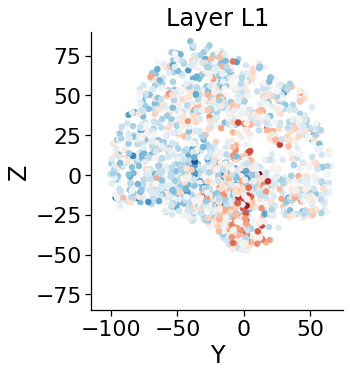

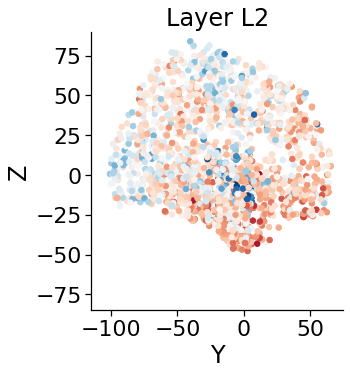

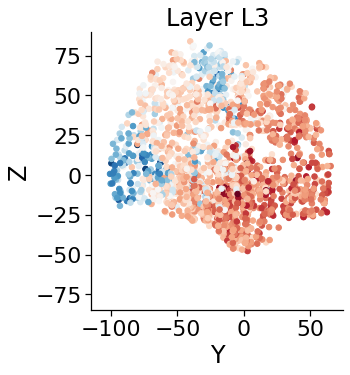

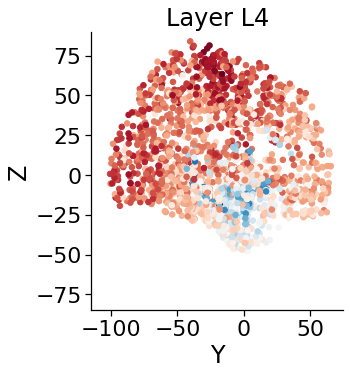

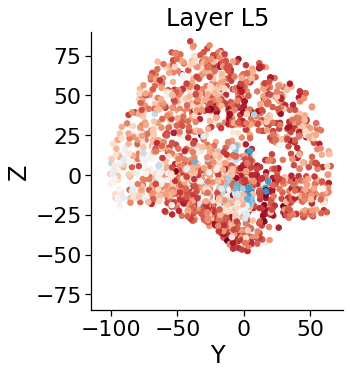

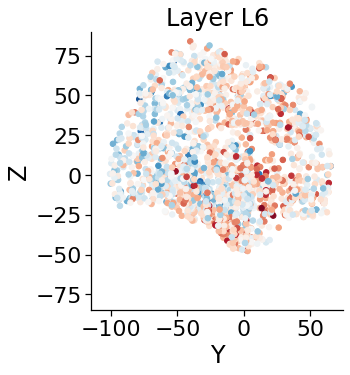

In [133]:
for layer,genes in p2genes.items():
# colors
    cmap = sns.color_palette('RdBu_r',as_cmap=True)
    #sg = tfm_X[:,i]
    shared = list(set(genes) & set(bigdf.columns) & set(p1genes[layer]))
    sg = bigdf.loc[gdf[gdf.Cortical_Type.isin(['Association_Cortex',
                                              'Sensory'])].index,shared].mean(1).values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf[gdf.Cortical_Type.isin(['Association_Cortex',
                                              'Sensory'])], 
                   fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  )
    
    # decorate
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('Layer %s'%layer)
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.show()

In [139]:
gdf.to_csv('/Users/jacobv/Science/PLS_GXP/gdf_with_layers.csv')

(0.0301126673254087, 0.1667534011352277)


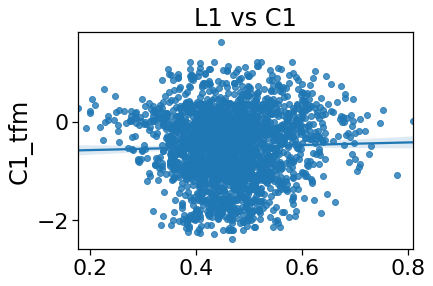

(0.3202418939039256, 1.5959673172868972e-51)


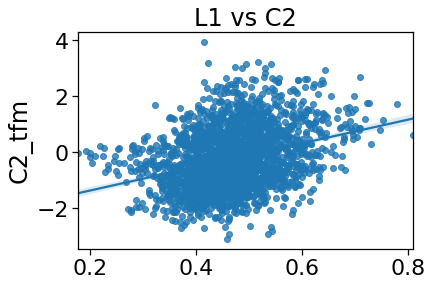

(-0.08421540339614766, 0.00010750312172788543)


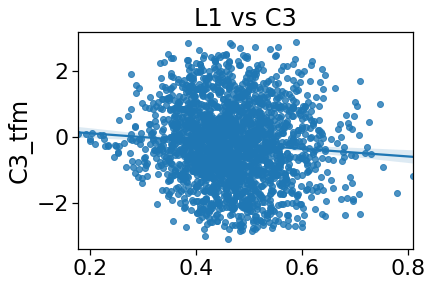

(-0.03504867393761858, 0.10750879237432968)


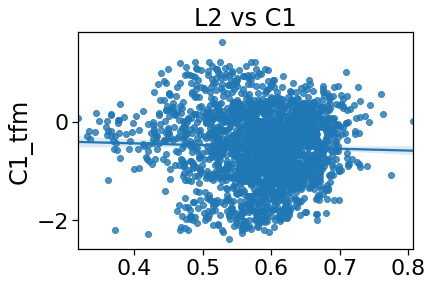

(0.10930558889272067, 4.827755837455329e-07)


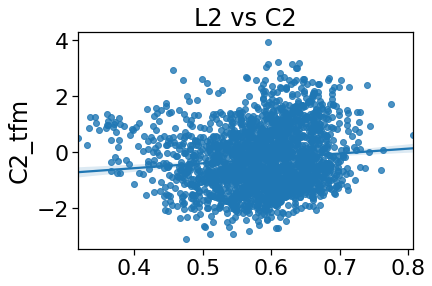

(-0.41134749458619196, 5.892675436646562e-87)


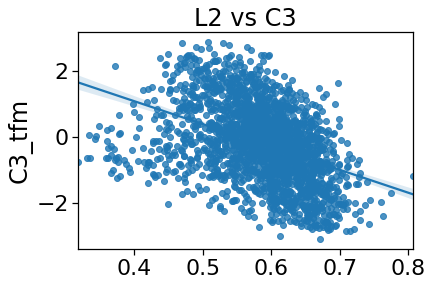

(-0.11281784793029526, 2.0386054069512002e-07)


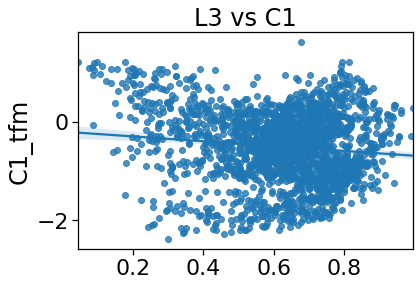

(0.5930887814109252, 1.0965757851658806e-200)


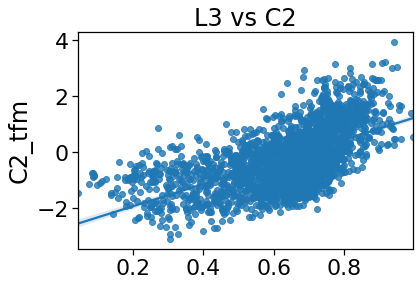

(-0.5021636602150351, 3.3709618268413465e-135)


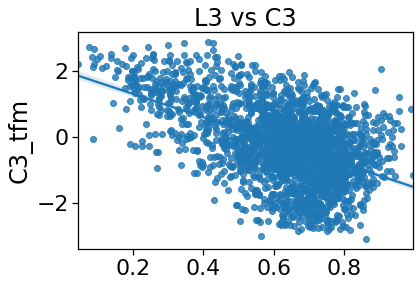

(-0.4318011804052894, 1.4044411850970837e-96)


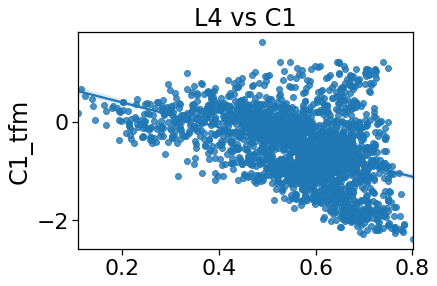

(-0.3958244224963492, 4.3549406004047286e-80)


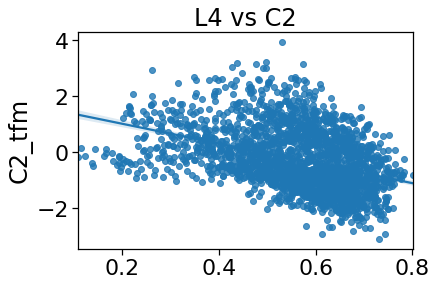

(0.4725799025977088, 7.4649713159737835e-118)


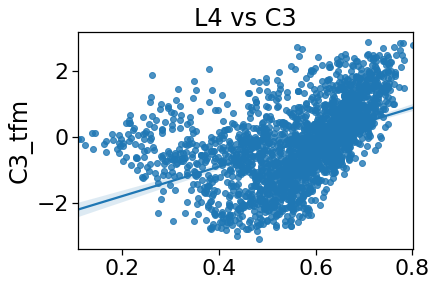

(-0.34380543726594603, 1.3214994164333924e-59)


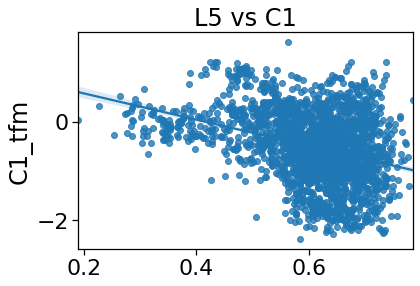

(0.048310010777004586, 0.026480717657071863)


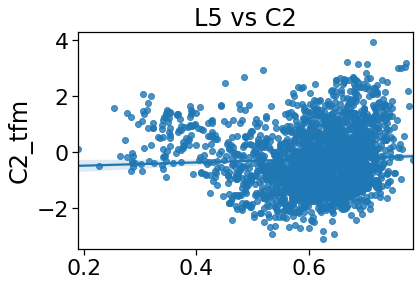

(-0.1916909646172428, 6.534498616249299e-19)


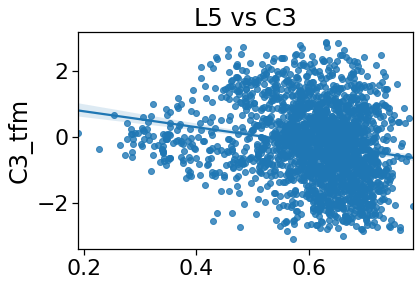

(-0.15614156910717056, 5.499450087922204e-13)


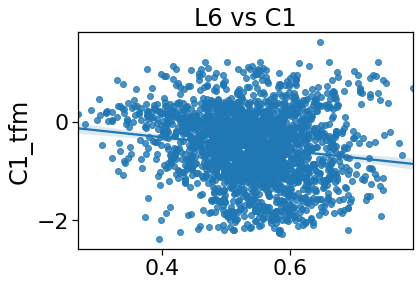

(0.2415398292332715, 2.1746285753458058e-29)


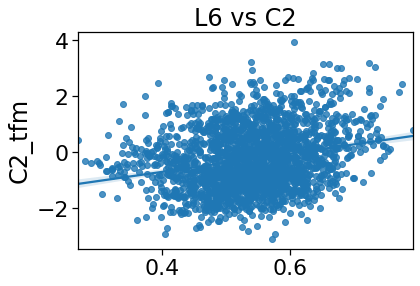

(-0.1432332392598227, 3.8538867792152585e-11)


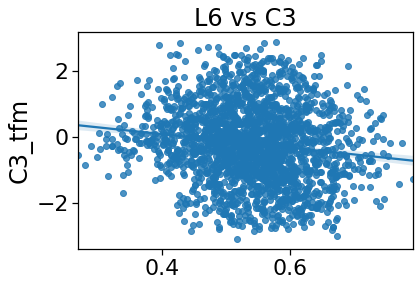

In [138]:
for layer,genes in p2genes.items():
# colors
    shared = list(set(genes) & set(bigdf.columns) & set(p1genes[layer]))
    gdf.loc[:,layer] = bigdf[shared].mean(1).values
    sg = bigdf.loc[gdf[gdf.Cortical_Type.isin(['Association_Cortex',
                                              'Sensory'])].index,shared].mean(1).values
    for i in range(1,4):
        c = gdf[gdf.Cortical_Type.isin(['Association_Cortex',
                                              'Sensory'])]['C%s_tfm'%i]
        sns.regplot(x=sg,y=c)
        print(stats.pearsonr(sg,c))
        plt.title('%s vs C%s'%(layer,i))
        plt.show()

In [53]:
Paper1 = jnk.parse('Table S5')

In [77]:
L123 = []
L4 = []
L56 = []
Other = []
for i,row in Paper1.iterrows():
    if any(row[['Layer1','Layer2','Layer3']].values == 1) and \
       all(row[['Layer4', 'Layer5', 'Layer6']].values==0):
        L123.append(i)
    elif row['Layer4'] == 1 and (all(row[['Layer1','Layer2','Layer3', 'Layer5', 'Layer6']
                                        ].values==0)):
        L4.append(i)
    elif any(row[['Layer5','Layer6',]].values == 1) and \
       all(row[['Layer4', 'Layer1', 'Layer2','Layer3']].values==0):
        L56.append(i)
    else:
        Other.append(i)